# English

## GPT-4o-mini

In [ ]:
import pandas as pd
import glob
import os

# ─────── Load all concise rewrite files ───────
file_paths = [
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gpt_4o_mini/en/concise_rewrites_10.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gpt_4o_mini/en/concise_rewrites_30.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gpt_4o_mini/en/concise_rewrites_20.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gpt_4o_mini/en/concise_rewrites_40.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gpt_4o_mini/en/concise_rewrites_50.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gpt_4o_mini/en/concise_rewrites_60.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gpt_4o_mini/en/concise_rewrites_70.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gpt_4o_mini/en/concise_rewrites_80.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gpt_4o_mini/en/concise_rewrites_90.csv",
]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        
        # Extract percentage from filename (e.g. "20", "40", etc.)
        pct = int(file.split("_")[-1].replace(".csv", ""))
        df["trim_percent"] = pct
        
        # Compute word count for rewritten explanation
        if "rewritten_explanation" in df.columns:
            df["rewritten_word_count"] = (
                df["rewritten_explanation"]
                .astype(str)
                .apply(lambda x: len(x.split()))
            )
        
        dfs.append(df)
    else:
        print(f"⚠️ File not found: {file}")

# ─────── Combine all into one DataFrame ───────
all_data = pd.concat(dfs, ignore_index=True)

# ─────── Summary per trim_percent ───────
summary = (
    all_data.groupby("trim_percent")["rewritten_word_count"]
    .describe()
    .reset_index()
)

print("Summary of rewritten word counts by trim percent:")
print(summary)

# ─────── Preview combined data ───────
print("\nCombined Data Sample:")
all_data.head()


Summary of rewritten word counts by trim percent:
   trim_percent   count       mean       std   min   25%   50%   75%   max
0            10  2581.0   5.411468  1.200940   2.0   5.0   5.0   6.0  15.0
1            20  2581.0   9.313832  2.115813   3.0   8.0   9.0  10.0  26.0
2            30  2581.0  14.204184  3.444094   7.0  12.0  14.0  16.0  37.0
3            40  2581.0  19.629213  4.676187   9.0  16.0  19.0  22.0  53.0
4            50  2581.0  24.584270  5.480229   1.0  21.0  24.0  28.0  60.0
5            60  2581.0  29.091825  6.549195  13.0  25.0  28.0  33.0  80.0
6            70  2581.0  33.434715  7.686802   1.0  28.0  33.0  38.0  84.0
7            80  2581.0  37.175126  8.306597   1.0  31.0  37.0  42.0  87.0
8            90  2581.0  40.294072  8.872040   1.0  34.0  40.0  46.0  95.0

Combined Data Sample:


,row_id,question_id,actual_answer,prediction,is_correct,split,question,choice_A,choice_B,choice_C,choice_D,original_words,length_constraint_percent,target_word_limit,original_explanation,rewritten_answer,rewritten_explanation,rewritten_word_count,raw_output,trim_percent
0,0,Mercury_SC_415702,A,A,True,train,George wants to warm his hands quickly by rubb...,dry palms,wet palms,palms covered with oil,palms covered with lotion,61,10,6,Dry palms will produce the most heat when rubb...,A,Friction is highest with dry surfaces.,6,<answer>A</answer>\n<concise_explanation>\nFri...,10
1,1,MCAS_2009_5_6516,B,B,True,train,Which of the following statements best explain...,The refrigerator door is smooth.,The refrigerator door contains iron.,The refrigerator door is a good conductor.,The refrigerator door has electric wires in it.,53,10,5,The refrigerator door is typically made of met...,B,Iron in the door attracts magnets.,6,<answer>B</answer>\n<concise_explanation>\nIro...,10
2,2,Mercury_7233695,B,B,True,train,A fold observed in layers of sedimentary rock ...,cooling of flowing magma.,converging of crustal plates.,deposition of river sediments.,solution of carbonate minerals.,44,10,4,Folds in sedimentary rock layers are primarily...,B,Tectonic forces cause folding.,4,<answer>B</answer>\n<concise_explanation>\nTec...,10
3,3,Mercury_7041615,D,D,True,train,Which of these do scientists offer as the most...,worldwide disease,global mountain building,rise of mammals that preyed upon plants and an...,impact of an asteroid created dust that blocke...,64,10,6,Scientists widely support the asteroid impact ...,D,"Asteroid impact blocked sunlight, disrupting e...",6,<answer>D</answer>\n<concise_explanation>\nAst...,10
4,4,Mercury_7041860,B,B,True,train,A boat is acted on by a river current flowing ...,west,east,north,south,61,10,6,"The boat is traveling northeast, which means i...",B,Wind must come from the east.,6,<answer>B</answer> \n<concise_explanation>Win...,10


In [2]:
print("Columns:", all_data.columns.tolist())
print("\nMissing values per column:")
print(all_data.isnull().sum())


Columns: ['row_id', 'question_id', 'actual_answer', 'prediction', 'is_correct', 'split', 'question', 'choice_A', 'choice_B', 'choice_C', 'choice_D', 'original_words', 'length_constraint_percent', 'target_word_limit', 'original_explanation', 'rewritten_answer', 'rewritten_explanation', 'rewritten_word_count', 'raw_output', 'trim_percent']

Missing values per column:
row_id                       0
question_id                  0
actual_answer                0
prediction                   0
is_correct                   0
split                        0
question                     0
choice_A                     0
choice_B                     0
choice_C                     0
choice_D                     0
original_words               0
length_constraint_percent    0
target_word_limit            0
original_explanation         0
rewritten_answer             0
rewritten_explanation        0
rewritten_word_count         0
raw_output                   0
trim_percent                 0
dtype: int64

In [5]:
if "rewritten_explanation" in all_data.columns:
    print("\nEmpty rewritten_explanation rows:")
    print(all_data[all_data["rewritten_explanation"].isna() | (all_data["rewritten_explanation"].str.strip() == "")].shape[0])



Empty rewritten_explanation rows:
0


In [6]:
print("\nWord count stats:")
print(all_data["rewritten_word_count"].describe())



Word count stats:
count    23229.000000
mean        23.682078
std         13.119310
min          1.000000
25%         12.000000
50%         23.000000
75%         33.000000
max         95.000000
Name: rewritten_word_count, dtype: float64


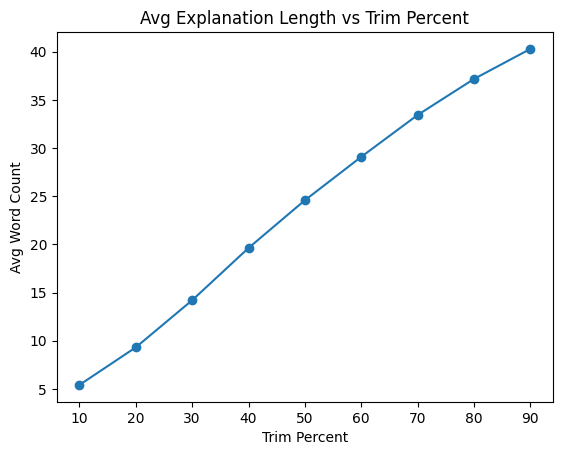

In [7]:
import matplotlib.pyplot as plt

summary_plot = (
    all_data.groupby("trim_percent")["rewritten_word_count"]
    .mean()
    .reset_index()
)

plt.plot(summary_plot["trim_percent"], summary_plot["rewritten_word_count"], marker="o")
plt.xlabel("Trim Percent")
plt.ylabel("Avg Word Count")
plt.title("Avg Explanation Length vs Trim Percent")
plt.show()


In [3]:
import pandas as pd
import os

# File paths
file_paths = [
    "results_masked_0.csv",
    "results_masked_20.csv",
    "results_masked_40.csv",
    "results_masked_60.csv",
    "results_masked_80.csv",
]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        
        # Extract % from filename (baseline 0 means no constraint)
        pct = int(file.split("_")[-1].replace(".csv", ""))
        df["constraint_percent"] = pct
        
        dfs.append(df)
    else:
        print(f"⚠️ File not found: {file}")

# Combine all results
eval_data = pd.concat(dfs, ignore_index=True)

print("Shape:", eval_data.shape)
print("Columns:", eval_data.columns.tolist())
print("\nPreview:")
eval_data.head()


Shape: (500, 16)
Columns: ['index', 'question', 'options', 'gold', 'masked_explanation', 'pred_noexp', 'prob_noexp', 'pred_exp', 'prob_exp', 'is_correct_noexp', 'is_correct_exp', 'sufficiency', 'usefulness', 'probs_noexp', 'probs_exp', 'constraint_percent']

Preview:


,index,question,options,gold,masked_explanation,pred_noexp,prob_noexp,pred_exp,prob_exp,is_correct_noexp,is_correct_exp,sufficiency,usefulness,probs_noexp,probs_exp,constraint_percent
0,810,What is the greatest contributor to air pollut...,"['factories', 'automobiles', 'power plants', '...",B,[MASK] are the greatest contributor to air pol...,B,0.783180,B,0.932937,True,True,True,True,[0.17475113 0.78318024 0.01841863 0.02364999],[0.05940813 0.9329367 0.00430351 0.00335158],0
1,1448,Irene needs to join two boards together. Which...,"['glue', 'screws', 'nails', 'saw']",D,"A [MASK] is a tool used for cutting materials,...",D,0.843129,D,0.753315,True,True,True,False,[0.1476629 0.00833057 0.00087804 0.84312856],[2.4361219e-01 2.3882899e-03 6.8425649e-04 7.5...,0
2,762,Which group consists only of living things?,"['rabbit, seed, bird', 'seed, bird, wind', 'Vo...",A,Option [MASK] consists of [MASK] rabbit and [M...,A,0.885185,A,0.782473,True,True,True,False,[0.88518536 0.0076285 0.09293412 0.01425191],[0.78247297 0.09400225 0.07320903 0.05031578],0
3,318,What enabled Galileo in the 17th century to se...,['Jupiter came close to Earth during his lifet...,C,Galileo was able to see the moons of Jupiter b...,A,0.495411,C,0.976625,False,True,True,True,[0.49541065 0.00430292 0.49541065 0.00487584],[2.2856150e-02 3.6943523e-04 9.7662520e-01 1.4...,0
4,962,Food webs show feeding relationships among dif...,"['to recycle nutrients into soil', 'to convert...",A,Decomposers play [MASK] crucial role in food w...,A,0.971438,A,0.997277,True,True,True,True,[0.9714381 0.01373557 0.01212159 0.00270469],[9.9727708e-01 8.1508048e-04 1.5227708e-03 3.8...,0



📊 Summary per Constraint:
   removed_percent  prob_exp  masked_exp_len
0                0  0.936555       57.185587
1               90  0.932254       39.905850
2               80  0.933008       36.798528
3               70  0.927384       33.139868
4               60  0.922208       28.840372
5               50  0.918724       24.393258
6               40  0.913374       19.459512
7               30  0.906248       14.075552
8               20  0.897906        9.247191
9               10  0.882047        5.385122


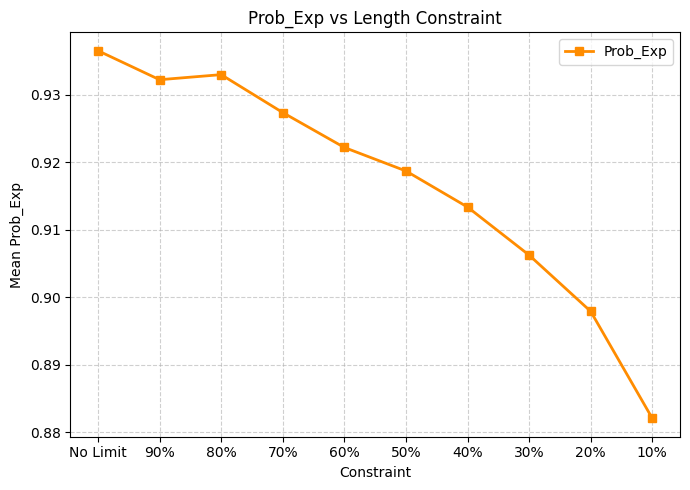

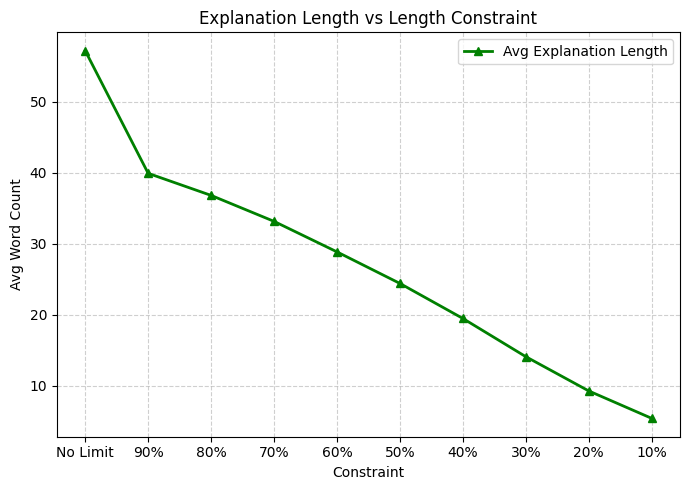

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ─────── Load All Eval CSVs ───────
file_paths = [
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/results_masked_0.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/results_masked_10.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/results_masked_20.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/results_masked_30.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/results_masked_40.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/results_masked_50.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/results_masked_60.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/results_masked_70.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/results_masked_80.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/results_masked_90.csv",
]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        removed_pct = int(file.split("_")[-1].replace(".csv", ""))  # e.g. 20
        df["removed_percent"] = removed_pct

        # Compute explanation length
        if "masked_explanation" in df.columns:
            df["masked_exp_len"] = df["masked_explanation"].astype(str).apply(lambda x: len(x.split()))

        dfs.append(df)

eval_data = pd.concat(dfs, ignore_index=True)

# ─────── Aggregate ───────
metrics = eval_data.groupby("removed_percent").agg({
    "prob_exp": "mean",
    "masked_exp_len": "mean"
}).reset_index()

# ✅ CHANGED: Reverse order - start with highest constraint
order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
labels = ["No Limit", "90%", "80%", "70%", "60%", "50%", "40%", "30%", "20%", "10%"]
metrics = metrics.set_index("removed_percent").loc[order].reset_index()

print("\n📊 Summary per Constraint:")
print(metrics)

# ─────── Plot Prob_Exp ───────
plt.figure(figsize=(7,5))
plt.plot(labels, metrics["prob_exp"], marker="s", color="darkorange", linewidth=2, label="Prob_Exp")
plt.xlabel("Constraint")
plt.ylabel("Mean Prob_Exp")
plt.title("Prob_Exp vs Length Constraint")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ─────── Plot Explanation Length ───────
plt.figure(figsize=(7,5))
plt.plot(labels, metrics["masked_exp_len"], marker="^", color="green", linewidth=2, label="Avg Explanation Length")
plt.xlabel("Constraint")
plt.ylabel("Avg Word Count")
plt.title("Explanation Length vs Length Constraint")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# ─────── Basic sanity checks ───────
print("Missing values per column:")
print(eval_data.isnull().sum())

print("\nUnique gold labels:", eval_data["gold"].unique())

# Check predictions match options
invalid_preds_noexp = eval_data[~eval_data["pred_noexp"].isin(eval_data["options"])]
invalid_preds_exp = eval_data[~eval_data["pred_exp"].isin(eval_data["options"])]
print(f"\nInvalid pred_noexp: {len(invalid_preds_noexp)}")
print(f"Invalid pred_exp: {len(invalid_preds_exp)}")

# Check probability ranges
for col in ["prob_noexp", "prob_exp", "sufficiency", "usefulness"]:
    if col in eval_data.columns:
        print(f"\n{col} range: {eval_data[col].min()} → {eval_data[col].max()}")

# Check boolean correctness columns
print("\nUnique values in correctness flags:")
print("is_correct_noexp:", eval_data["is_correct_noexp"].unique())
print("is_correct_exp:", eval_data["is_correct_exp"].unique())

# Optional: check distribution sums
import ast
def check_prob_sum(row, col):
    try:
        probs = ast.literal_eval(row[col])
        return abs(sum(probs) - 1) < 1e-3
    except:
        return False

if "probs_exp" in eval_data.columns:
    valid_sums = eval_data.apply(lambda r: check_prob_sum(r, "probs_exp"), axis=1).mean()
    print(f"\nprobs_exp valid distribution: {valid_sums*100:.1f}% rows OK")

if "probs_noexp" in eval_data.columns:
    valid_sums = eval_data.apply(lambda r: check_prob_sum(r, "probs_noexp"), axis=1).mean()
    print(f"probs_noexp valid distribution: {valid_sums*100:.1f}% rows OK")


Missing values per column:
index                 0
question              0
options               0
gold                  0
masked_explanation    0
pred_noexp            0
prob_noexp            0
pred_exp              0
prob_exp              0
is_correct_noexp      0
is_correct_exp        0
sufficiency           0
usefulness            0
probs_noexp           0
probs_exp             0
removed_percent       0
masked_exp_len        0
dtype: int64

Unique gold labels: ['A' 'B' 'D' 'C']

Invalid pred_noexp: 25810
Invalid pred_exp: 25810

prob_noexp range: 0.2885095477104187 → 0.9997153878211976

prob_exp range: 0.2953920662403106 → 0.9999815225601196

sufficiency range: False → True

usefulness range: False → True

Unique values in correctness flags:
is_correct_noexp: [False  True]
is_correct_exp: [ True False]

probs_exp valid distribution: 0.0% rows OK
probs_noexp valid distribution: 0.0% rows OK


In [11]:
# ببینیم داده‌ها چه شکلی ذخیره شده‌اند
print("Sample options:", eval_data["options"].iloc[0])
print("Type:", type(eval_data["options"].iloc[0]))

print("\nSample probs_exp:", eval_data["probs_exp"].iloc[0])
print("Type:", type(eval_data["probs_exp"].iloc[0]))


Sample options: ['dry palms', 'wet palms', 'palms covered with oil', 'palms covered with lotion']
Type: <class 'list'>

Sample probs_exp: [0.9949185  0.00130434 0.00101582 0.00276129]
Type: <class 'str'>


In [12]:
import re
import numpy as np

def parse_probs(s):
    try:
        # حذف براکت‌ها
        s = s.strip("[]")
        # اسپلیت بر اساس فاصله
        nums = [float(x) for x in re.split(r"\s+", s.strip()) if x]
        return nums
    except Exception as e:
        print("Parse error:", s, e)
        return []

# تست روی یک نمونه
sample = eval_data["probs_exp"].iloc[0]
print("Parsed:", parse_probs(sample), "Sum:", sum(parse_probs(sample)))


Parsed: [0.9949185, 0.00130434, 0.00101582, 0.00276129] Sum: 0.9999999500000001


In [13]:
eval_data["probs_exp"] = eval_data["probs_exp"].apply(parse_probs)
eval_data["probs_noexp"] = eval_data["probs_noexp"].apply(parse_probs)

# چک کنیم چند درصد sum≈1 هست
valid_exp = eval_data["probs_exp"].apply(lambda p: abs(sum(p) - 1) < 1e-3).mean()
valid_noexp = eval_data["probs_noexp"].apply(lambda p: abs(sum(p) - 1) < 1e-3).mean()

print(f"probs_exp valid distributions: {valid_exp*100:.1f}%")
print(f"probs_noexp valid distributions: {valid_noexp*100:.1f}%")


probs_exp valid distributions: 100.0%
probs_noexp valid distributions: 100.0%



📊 Summary per constraint level:
   removed_percent  acc_noexp   acc_exp  sufficiency_rate  usefulness_rate  \
0                0    0.71174  0.893452          0.893452         0.801240   
1               10    0.71174  0.832623          0.832623         0.686556   
2               20    0.71174  0.852383          0.852383         0.717164   
3               30    0.71174  0.862844          0.862844         0.743123   
4               40    0.71174  0.873692          0.873692         0.766757   
5               50    0.71174  0.876404          0.876404         0.783417   
6               60    0.71174  0.880279          0.880279         0.782642   
7               70    0.71174  0.890740          0.890740         0.802790   
8               80    0.71174  0.893065          0.893065         0.806664   
9               90    0.71174  0.892290          0.892290         0.808214   

   avg_conf_noexp  avg_conf_exp  avg_entropy_noexp  avg_entropy_exp  \
0        0.807188      0.936555      

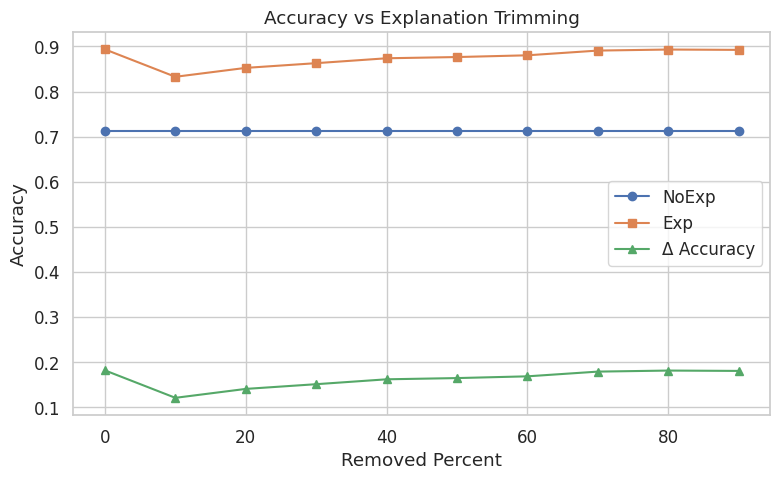

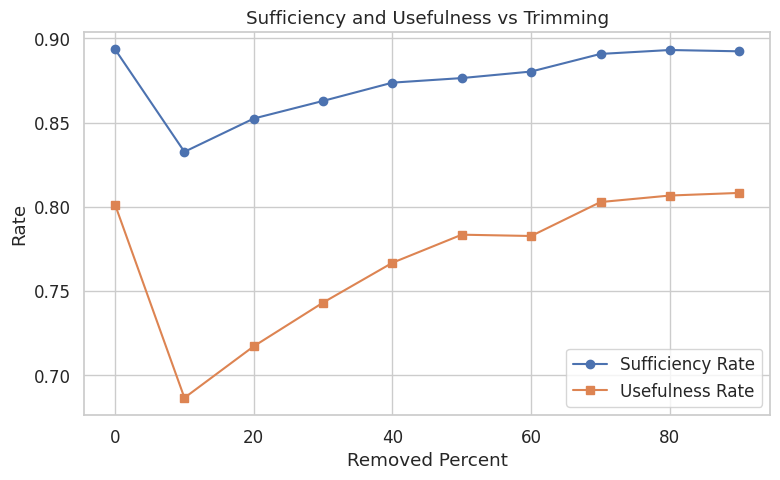

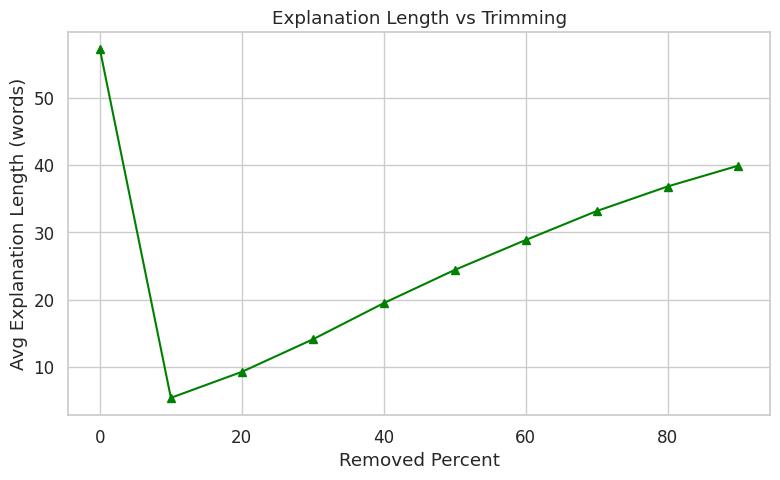

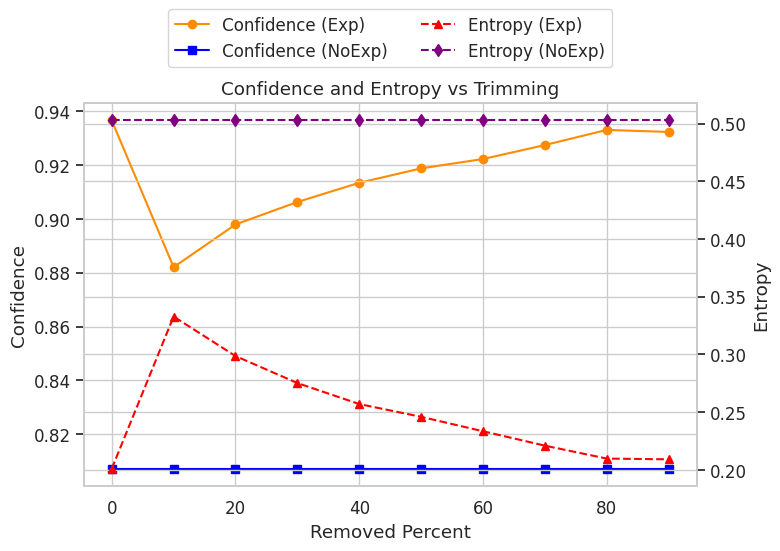

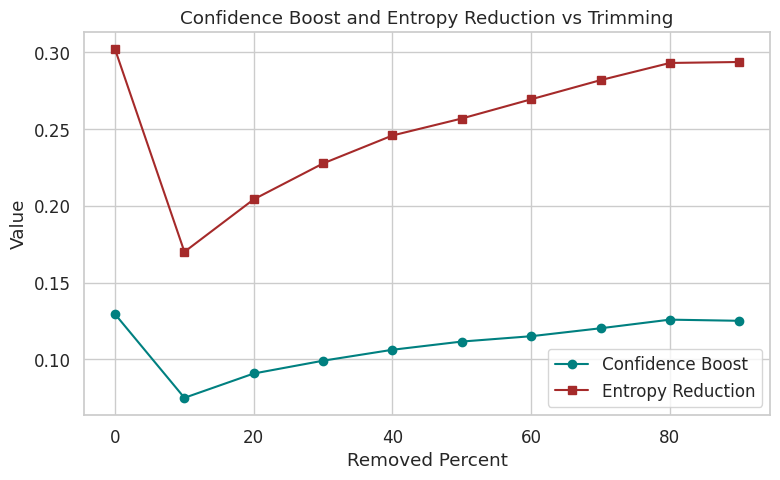

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─────── Helper: entropy ───────
def entropy(probs):
    probs = np.array(probs, dtype=float)
    probs = probs[probs > 0]   # avoid log(0)
    return -np.sum(probs * np.log(probs))

# ─────── Compute metrics per row ───────
eval_data["conf_noexp"] = eval_data["prob_noexp"]
eval_data["conf_exp"] = eval_data["prob_exp"]

# Entropy
eval_data["entropy_noexp"] = eval_data["probs_noexp"].apply(entropy)
eval_data["entropy_exp"] = eval_data["probs_exp"].apply(entropy)

# Confidence boost and entropy reduction
eval_data["conf_boost"] = eval_data["conf_exp"] - eval_data["conf_noexp"]
eval_data["entropy_reduction"] = eval_data["entropy_noexp"] - eval_data["entropy_exp"]

# ─────── Aggregate by removed_percent ───────
metrics = eval_data.groupby("removed_percent").agg(
    acc_noexp=("is_correct_noexp", "mean"),
    acc_exp=("is_correct_exp", "mean"),
    sufficiency_rate=("sufficiency", "mean"),
    usefulness_rate=("usefulness", "mean"),
    avg_conf_noexp=("conf_noexp", "mean"),
    avg_conf_exp=("conf_exp", "mean"),
    avg_entropy_noexp=("entropy_noexp", "mean"),
    avg_entropy_exp=("entropy_exp", "mean"),
    avg_conf_boost=("conf_boost", "mean"),
    avg_entropy_reduction=("entropy_reduction", "mean"),
    avg_exp_len=("masked_exp_len", "mean")
).reset_index()

metrics["delta_acc"] = metrics["acc_exp"] - metrics["acc_noexp"]

print("\n📊 Summary per constraint level:")
print(metrics)

# ─────── PLOTS ───────
sns.set(style="whitegrid", font_scale=1.1)

# 1. Accuracy vs Constraint
plt.figure(figsize=(8,5))
plt.plot(metrics["removed_percent"], metrics["acc_noexp"], marker="o", label="NoExp")
plt.plot(metrics["removed_percent"], metrics["acc_exp"], marker="s", label="Exp")
plt.plot(metrics["removed_percent"], metrics["delta_acc"], marker="^", label="Δ Accuracy")
plt.xlabel("Removed Percent")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Explanation Trimming")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Sufficiency & Usefulness
plt.figure(figsize=(8,5))
plt.plot(metrics["removed_percent"], metrics["sufficiency_rate"], marker="o", label="Sufficiency Rate")
plt.plot(metrics["removed_percent"], metrics["usefulness_rate"], marker="s", label="Usefulness Rate")
plt.xlabel("Removed Percent")
plt.ylabel("Rate")
plt.title("Sufficiency and Usefulness vs Trimming")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Explanation length
plt.figure(figsize=(8,5))
plt.plot(metrics["removed_percent"], metrics["avg_exp_len"], marker="^", color="green")
plt.xlabel("Removed Percent")
plt.ylabel("Avg Explanation Length (words)")
plt.title("Explanation Length vs Trimming")
plt.tight_layout()
plt.show()

# 4. Confidence & Entropy
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(metrics["removed_percent"], metrics["avg_conf_exp"], marker="o", color="darkorange", label="Confidence (Exp)")
ax1.plot(metrics["removed_percent"], metrics["avg_conf_noexp"], marker="s", color="blue", label="Confidence (NoExp)")
ax1.set_xlabel("Removed Percent")
ax1.set_ylabel("Confidence")
ax2 = ax1.twinx()
ax2.plot(metrics["removed_percent"], metrics["avg_entropy_exp"], marker="^", color="red", linestyle="--", label="Entropy (Exp)")
ax2.plot(metrics["removed_percent"], metrics["avg_entropy_noexp"], marker="d", color="purple", linestyle="--", label="Entropy (NoExp)")
ax2.set_ylabel("Entropy")
ax1.set_title("Confidence and Entropy vs Trimming")

fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.12), ncol=2)
plt.tight_layout()
plt.show()

# 5. Confidence Boost & Entropy Reduction
plt.figure(figsize=(8,5))
plt.plot(metrics["removed_percent"], metrics["avg_conf_boost"], marker="o", color="teal", label="Confidence Boost")
plt.plot(metrics["removed_percent"], metrics["avg_entropy_reduction"], marker="s", color="brown", label="Entropy Reduction")
plt.xlabel("Removed Percent")
plt.ylabel("Value")
plt.title("Confidence Boost and Entropy Reduction vs Trimming")
plt.legend()
plt.tight_layout()
plt.show()


## LLAMA-4-Maverik

In [1]:
import pandas as pd
import glob
import os

# ─────── Load all concise rewrite files ───────
file_paths = [
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/llama_4_maverik/concise_rewrites_llama-4-maverick_10.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/llama_4_maverik/concise_rewrites_llama-4-maverick_20.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/llama_4_maverik/concise_rewrites_llama-4-maverick_30.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/llama_4_maverik/concise_rewrites_llama-4-maverick_40.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/llama_4_maverik/concise_rewrites_llama-4-maverick_50.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/llama_4_maverik/concise_rewrites_llama-4-maverick_60.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/llama_4_maverik/concise_rewrites_llama-4-maverick_70.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/llama_4_maverik/concise_rewrites_llama-4-maverick_80.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/llama_4_maverik/concise_rewrites_llama-4-maverick_90.csv",
]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        
        # Extract percentage from filename (e.g. "20", "40", etc.)
        pct = int(file.split("_")[-1].replace(".csv", ""))
        df["trim_percent"] = pct
        
        # Compute word count for rewritten explanation
        if "rewritten_explanation" in df.columns:
            df["rewritten_word_count"] = (
                df["rewritten_explanation"]
                .astype(str)
                .apply(lambda x: len(x.split()))
            )
        
        dfs.append(df)
    else:
        print(f"⚠️ File not found: {file}")

# ─────── Combine all into one DataFrame ───────
all_data = pd.concat(dfs, ignore_index=True)

# ─────── Summary per trim_percent ───────
summary = (
    all_data.groupby("trim_percent")["rewritten_word_count"]
    .describe()
    .reset_index()
)

print("Summary of rewritten word counts by trim percent:")
print(summary)

# ─────── Preview combined data ───────
print("\nCombined Data Sample:")
all_data.head()


Summary of rewritten word counts by trim percent:
   trim_percent   count       mean       std  min   25%   50%   75%    max
0            10  2581.0   5.164665  1.368955  1.0   4.0   5.0   6.0   29.0
1            20  2581.0   9.605192  2.881019  1.0   8.0   9.0  11.0   71.0
2            30  2581.0  14.141418  4.140338  1.0  12.0  14.0  16.0  113.0
3            40  2581.0  18.401007  5.149470  1.0  16.0  18.0  21.0  144.0
4            50  2581.0  22.179388  6.585394  1.0  19.0  22.0  25.0  210.0
5            60  2581.0  25.508330  7.151437  1.0  22.0  25.0  29.0  197.0
6            70  2581.0  28.867881  9.168660  1.0  24.0  28.0  33.0  312.0
7            80  2581.0  31.923286  8.548013  1.0  26.0  31.0  36.0  178.0
8            90  2581.0  35.198760  9.562504  1.0  29.0  34.0  41.0  193.0

Combined Data Sample:


,row_id,question_id,actual_answer,prediction,is_correct,split,question,choice_A,choice_B,choice_C,choice_D,original_words,length_constraint_percent,target_word_limit,original_explanation,rewritten_answer,rewritten_explanation,rewritten_word_count,raw_output,trim_percent
0,0,0,A,A,1,train,George wants to warm his hands quickly by rubb...,dry palms,wet palms,palms covered with oil,palms covered with lotion,43,10,4,Rubbing hands together generates heat due to f...,A,Friction generates heat maximally,4,<answer>A</answer>\n<concise_explanation>Frict...,10
1,1,1,B,B,1,train,Which of the following statements best explain...,The refrigerator door is smooth.,The refrigerator door contains iron.,The refrigerator door is a good conductor.,The refrigerator door has electric wires in it.,62,10,6,Magnets stick to a refrigerator door because t...,B,Ferromagnetic material attracts magnetic force...,6,<answer>B</answer>\n<concise_explanation>\nFer...,10
2,2,2,B,B,1,train,A fold observed in layers of sedimentary rock ...,cooling of flowing magma.,converging of crustal plates.,deposition of river sediments.,solution of carbonate minerals.,48,10,4,Folds in sedimentary rock layers are primarily...,B,Tectonic forces cause deformation,4,<answer>B</answer>\n<concise_explanation>\nTec...,10
3,3,3,D,D,1,train,Which of these do scientists offer as the most...,worldwide disease,global mountain building,rise of mammals that preyed upon plants and an...,impact of an asteroid created dust that blocke...,59,10,5,The most widely accepted scientific explanatio...,D,Asteroid impact caused climate disruption,5,<answer>D</answer>\n<concise_explanation>\nAst...,10
4,4,4,B,B,1,train,A boat is acted on by a river current flowing ...,west,east,north,south,63,10,6,The boat is moving northeast due to the combin...,B,Force has easterly component to offset,6,<answer>B</answer>\n<concise_explanation>Force...,10


In [2]:
print("Columns:", all_data.columns.tolist())
print("\nMissing values per column:")
print(all_data.isnull().sum())


Columns: ['row_id', 'question_id', 'actual_answer', 'prediction', 'is_correct', 'split', 'question', 'choice_A', 'choice_B', 'choice_C', 'choice_D', 'original_words', 'length_constraint_percent', 'target_word_limit', 'original_explanation', 'rewritten_answer', 'rewritten_explanation', 'rewritten_word_count', 'raw_output', 'trim_percent']

Missing values per column:
row_id                       0
question_id                  0
actual_answer                0
prediction                   0
is_correct                   0
split                        0
question                     0
choice_A                     0
choice_B                     0
choice_C                     0
choice_D                     0
original_words               0
length_constraint_percent    0
target_word_limit            0
original_explanation         0
rewritten_answer             0
rewritten_explanation        1
rewritten_word_count         0
raw_output                   1
trim_percent                 0
dtype: int64

In [7]:
if "rewritten_explanation" in all_data.columns:
    print("\nEmpty rewritten_explanation rows:")
    print(all_data[all_data["rewritten_explanation"].isna() | (all_data["rewritten_explanation"].str.strip() == "")].shape[0])
    print(all_data[all_data["rewritten_explanation"].isna()])



Empty rewritten_explanation rows:
1
       row_id  question_id actual_answer prediction  is_correct split  \
22410    1762         1762             D          C           0  test   

                                                question choice_A choice_B  \
22410  An atom of chromium has 24 protons, 28 neutron...       24       28   

      choice_C choice_D  original_words  length_constraint_percent  \
22410       48       52              58                         90   

       target_word_limit                               original_explanation  \
22410                 52  The nucleus of an atom contains protons and ne...   

      rewritten_answer rewritten_explanation  rewritten_word_count raw_output  \
22410                C                   NaN                     1        NaN   

       trim_percent  
22410            90  



📊 Summary per Constraint:
   removed_percent  prob_exp  masked_exp_len
0                0  0.934367       55.068966
1               90  0.924066       35.147230
2               80  0.920364       31.853933
3               70  0.918394       28.803177
4               60  0.912491       25.464161
5               50  0.908620       22.134444
6               40  0.903462       18.367299
7               30  0.894504       14.124758
8               20  0.884973        9.593568
9               10  0.868946        5.162728


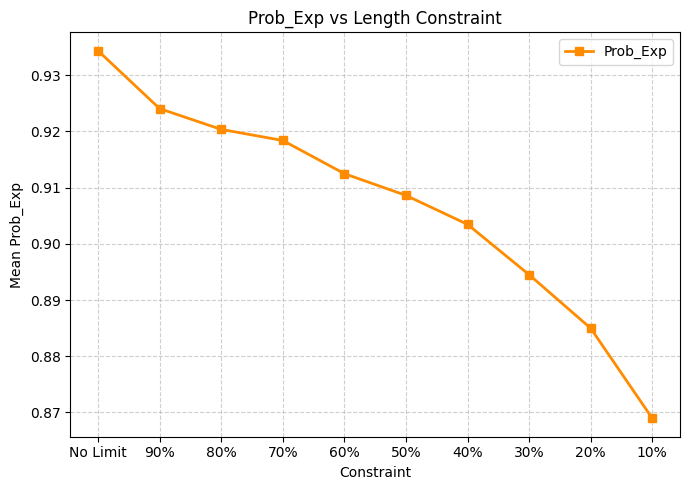

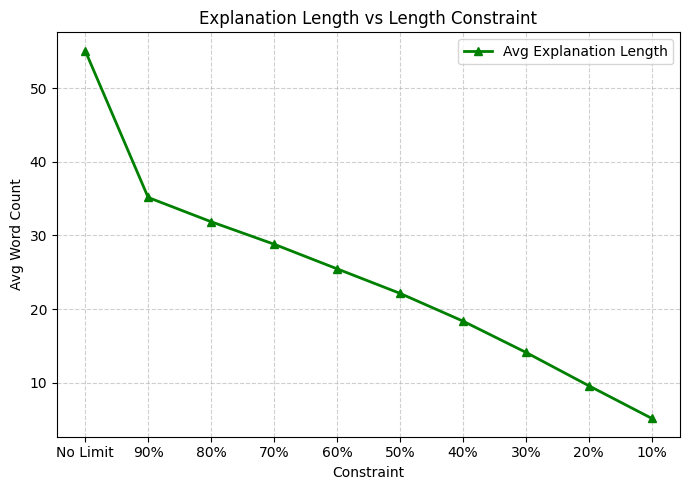

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ─────── Load All Eval CSVs ───────
file_paths = [
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_masked_0.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_masked_10.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_masked_20.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_masked_30.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_masked_40.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_masked_50.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_masked_60.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_masked_70.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_masked_80.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_masked_90.csv",
    

]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        removed_pct = int(file.split("_")[-1].replace(".csv", ""))  # e.g. 20
        df["removed_percent"] = removed_pct

        # Compute explanation length
        if "masked_explanation" in df.columns:
            df["masked_exp_len"] = df["masked_explanation"].astype(str).apply(lambda x: len(x.split()))

        dfs.append(df)

eval_data = pd.concat(dfs, ignore_index=True)

# ─────── Aggregate ───────
metrics = eval_data.groupby("removed_percent").agg({
    "prob_exp": "mean",
    "masked_exp_len": "mean"
}).reset_index()

# ✅ CHANGED: Reverse order - start with highest constraint
order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
labels = ["No Limit", "90%", "80%", "70%", "60%", "50%", "40%", "30%", "20%", "10%"]
metrics = metrics.set_index("removed_percent").loc[order].reset_index()

print("\n📊 Summary per Constraint:")
print(metrics)

# ─────── Plot Prob_Exp ───────
plt.figure(figsize=(7,5))
plt.plot(labels, metrics["prob_exp"], marker="s", color="darkorange", linewidth=2, label="Prob_Exp")
plt.xlabel("Constraint")
plt.ylabel("Mean Prob_Exp")
plt.title("Prob_Exp vs Length Constraint")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ─────── Plot Explanation Length ───────
plt.figure(figsize=(7,5))
plt.plot(labels, metrics["masked_exp_len"], marker="^", color="green", linewidth=2, label="Avg Explanation Length")
plt.xlabel("Constraint")
plt.ylabel("Avg Word Count")
plt.title("Explanation Length vs Length Constraint")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## Claude-3-haiku

In [1]:
import pandas as pd
import glob
import os

# ─────── Load all concise rewrite files ───────
file_paths = [
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/claude_3_haiku/concise_rewrites_claude-3-haiku_10.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/claude_3_haiku/concise_rewrites_claude-3-haiku_20.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/claude_3_haiku/concise_rewrites_claude-3-haiku_30.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/claude_3_haiku/concise_rewrites_claude-3-haiku_40.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/claude_3_haiku/concise_rewrites_claude-3-haiku_50.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/claude_3_haiku/concise_rewrites_claude-3-haiku_60.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/claude_3_haiku/concise_rewrites_claude-3-haiku_70.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/claude_3_haiku/concise_rewrites_claude-3-haiku_80.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/claude_3_haiku/concise_rewrites_claude-3-haiku_90.csv",
]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        
        # Extract percentage from filename (e.g. "20", "40", etc.)
        pct = int(file.split("_")[-1].replace(".csv", ""))
        df["trim_percent"] = pct
        
        # Compute word count for rewritten explanation
        if "rewritten_explanation" in df.columns:
            df["rewritten_word_count"] = (
                df["rewritten_explanation"]
                .astype(str)
                .apply(lambda x: len(x.split()))
            )
        
        dfs.append(df)
    else:
        print(f"⚠️ File not found: {file}")

# ─────── Combine all into one DataFrame ───────
all_data = pd.concat(dfs, ignore_index=True)

# ─────── Summary per trim_percent ───────
summary = (
    all_data.groupby("trim_percent")["rewritten_word_count"]
    .describe()
    .reset_index()
)

print("Summary of rewritten word counts by trim percent:")
print(summary)

# ─────── Preview combined data ───────
print("\nCombined Data Sample:")
all_data.head()


Summary of rewritten word counts by trim percent:
   trim_percent   count       mean       std   min   25%   50%   75%   max
0            10  2581.0   6.889578  2.151755   2.0   5.0   7.0   8.0  22.0
1            20  2581.0  11.974041  4.215386   4.0   9.0  11.0  14.0  35.0
2            30  2581.0  17.555599  5.273058   5.0  14.0  17.0  21.0  49.0
3            40  2581.0  21.533902  5.092108   7.0  18.0  22.0  25.0  49.0
4            50  2581.0  23.745835  4.986076   9.0  20.0  23.0  27.0  57.0
5            60  2581.0  25.538164  5.539131  11.0  22.0  25.0  29.0  56.0
6            70  2581.0  27.413793  6.378321   1.0  23.0  27.0  31.0  62.0
7            80  2581.0  29.554049  7.111943  13.0  24.0  29.0  34.0  60.0
8            90  2581.0  31.662146  7.784585  13.0  26.0  31.0  36.0  84.0

Combined Data Sample:


,row_id,question_id,actual_answer,prediction,is_correct,split,question,choice_A,choice_B,choice_C,choice_D,original_words,length_constraint_percent,target_word_limit,original_explanation,rewritten_answer,rewritten_explanation,rewritten_word_count,raw_output,trim_percent
0,0,0,A,A,1,train,George wants to warm his hands quickly by rubb...,dry palms,wet palms,palms covered with oil,palms covered with lotion,47,10,4,Rubbing dry palms together will produce the mo...,A,Dry skin generates most friction heat.,6,<answer>A</answer>\n<concise_explanation>\nDry...,10
1,1,1,B,B,0,train,Which of the following statements best explain...,The refrigerator door is smooth.,The refrigerator door contains iron.,The refrigerator door is a good conductor.,The refrigerator door has electric wires in it.,49,10,4,"The refrigerator door contains iron, which is ...",B,Refrigerator door contains iron.,4,<answer>B</answer>\n<concise_explanation>\nRef...,10
2,2,2,B,B,0,train,A fold observed in layers of sedimentary rock ...,cooling of flowing magma.,converging of crustal plates.,deposition of river sediments.,solution of carbonate minerals.,51,10,5,The folding of sedimentary rock layers most li...,B,Tectonic forces from converging plates.,5,<answer>B</answer>\n<concise_explanation>\nTec...,10
3,3,3,D,D,0,train,Which of these do scientists offer as the most...,worldwide disease,global mountain building,rise of mammals that preyed upon plants and an...,impact of an asteroid created dust that blocke...,78,10,7,The most recent scientific explanation for the...,D,"Asteroid impact blocked sunlight, disrupting p...",9,<answer>D</answer>\n<concise_explanation>\nAst...,10
4,4,4,B,B,0,train,A boat is acted on by a river current flowing ...,west,east,north,south,43,10,4,"The boat is traveling northeast, which means t...",B,Wind blowing from east.,4,<answer>B</answer>\n<concise_explanation>\nWin...,10



📊 Summary per Constraint:
   removed_percent  prob_exp  masked_exp_len
0                0  0.929116       57.371949
1               90  0.922947       31.168539
2               80  0.921072       29.100349
3               70  0.919569       26.977916
4               60  0.921090       25.135219
5               50  0.917220       23.370012
6               40  0.915361       21.184425
7               30  0.909141       17.257652
8               20  0.900159       11.751259
9               10  0.887981        6.786517


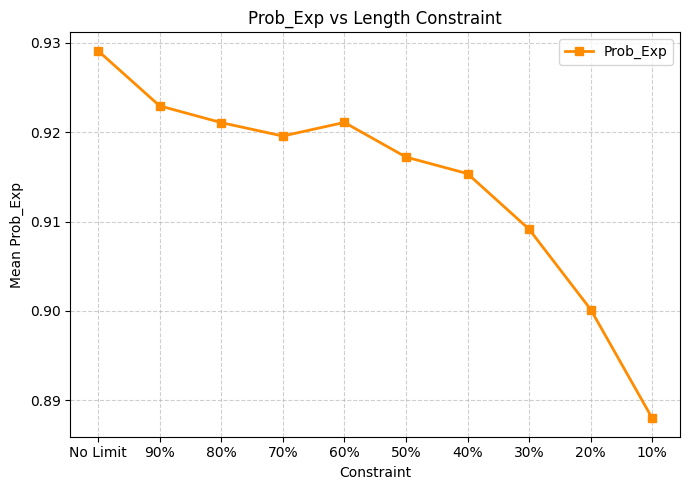

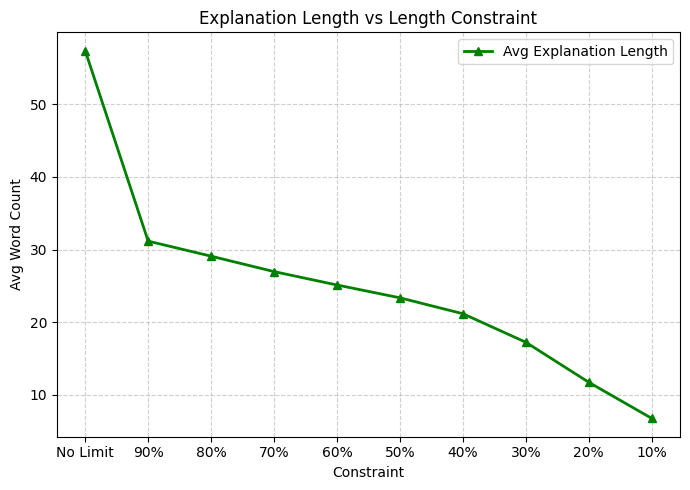

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ─────── Load All Eval CSVs ───────
file_paths = [
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_0.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_10.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_20.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_30.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_40.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_50.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_60.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_70.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_80.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_90.csv",
    

]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        removed_pct = int(file.split("_")[-1].replace(".csv", ""))  # e.g. 20
        df["removed_percent"] = removed_pct

        # Compute explanation length
        if "masked_explanation" in df.columns:
            df["masked_exp_len"] = df["masked_explanation"].astype(str).apply(lambda x: len(x.split()))

        dfs.append(df)

eval_data = pd.concat(dfs, ignore_index=True)

# ─────── Aggregate ───────
metrics = eval_data.groupby("removed_percent").agg({
    "prob_exp": "mean",
    "masked_exp_len": "mean"
}).reset_index()

# ✅ CHANGED: Reverse order - start with highest constraint
order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
labels = ["No Limit", "90%", "80%", "70%", "60%", "50%", "40%", "30%", "20%", "10%"]
metrics = metrics.set_index("removed_percent").loc[order].reset_index()

print("\n📊 Summary per Constraint:")
print(metrics)

# ─────── Plot Prob_Exp ───────
plt.figure(figsize=(7,5))
plt.plot(labels, metrics["prob_exp"], marker="s", color="darkorange", linewidth=2, label="Prob_Exp")
plt.xlabel("Constraint")
plt.ylabel("Mean Prob_Exp")
plt.title("Prob_Exp vs Length Constraint")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ─────── Plot Explanation Length ───────
plt.figure(figsize=(7,5))
plt.plot(labels, metrics["masked_exp_len"], marker="^", color="green", linewidth=2, label="Avg Explanation Length")
plt.xlabel("Constraint")
plt.ylabel("Avg Word Count")
plt.title("Explanation Length vs Length Constraint")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## Gemini-2-flash

In [3]:
import pandas as pd
import glob
import os

# ─────── Load all concise rewrite files ───────
file_paths = [
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gemini_2_flash/concise_rewrites_gemini-2.0-flash-001_10.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gemini_2_flash/concise_rewrites_gemini-2.0-flash-001_20.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gemini_2_flash/concise_rewrites_gemini-2.0-flash-001_30.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gemini_2_flash/concise_rewrites_gemini-2.0-flash-001_40.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gemini_2_flash/concise_rewrites_gemini-2.0-flash-001_50.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gemini_2_flash/concise_rewrites_gemini-2.0-flash-001_60.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gemini_2_flash/concise_rewrites_gemini-2.0-flash-001_70.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gemini_2_flash/concise_rewrites_gemini-2.0-flash-001_80.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gemini_2_flash/concise_rewrites_gemini-2.0-flash-001_90.csv",
]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        
        # Extract percentage from filename (e.g. "20", "40", etc.)
        pct = int(file.split("_")[-1].replace(".csv", ""))
        df["trim_percent"] = pct
        
        # Compute word count for rewritten explanation
        if "rewritten_explanation" in df.columns:
            df["rewritten_word_count"] = (
                df["rewritten_explanation"]
                .astype(str)
                .apply(lambda x: len(x.split()))
            )
        
        dfs.append(df)
    else:
        print(f"⚠️ File not found: {file}")

# ─────── Combine all into one DataFrame ───────
all_data = pd.concat(dfs, ignore_index=True)

# ─────── Summary per trim_percent ───────
summary = (
    all_data.groupby("trim_percent")["rewritten_word_count"]
    .describe()
    .reset_index()
)

print("Summary of rewritten word counts by trim percent:")
print(summary)

# ─────── Preview combined data ───────
print("\nCombined Data Sample:")
all_data.head()


Summary of rewritten word counts by trim percent:
   trim_percent   count       mean       std   min   25%   50%   75%   max
0            10  2581.0   3.894614  1.065916   2.0   3.0   4.0   4.0  12.0
1            20  2581.0   7.524990  2.140930   2.0   6.0   7.0   9.0  20.0
2            30  2581.0  11.559086  3.144716   3.0   9.0  11.0  13.0  29.0
3            40  2581.0  15.566060  3.964669   4.0  13.0  15.0  18.0  41.0
4            50  2581.0  19.301434  4.576121   6.0  16.0  19.0  22.0  46.0
5            60  2581.0  22.439752  5.315907   7.0  19.0  22.0  25.0  54.0
6            70  2581.0  25.285936  6.113683   1.0  21.0  24.0  28.0  56.0
7            80  2581.0  28.171639  6.856982  10.0  23.0  27.0  32.0  68.0
8            90  2581.0  30.819837  7.373355  12.0  25.0  30.0  36.0  59.0

Combined Data Sample:


,row_id,question_id,actual_answer,prediction,is_correct,split,question,choice_A,choice_B,choice_C,choice_D,original_words,length_constraint_percent,target_word_limit,original_explanation,rewritten_answer,rewritten_explanation,rewritten_word_count,raw_output,trim_percent
0,0,0,A,A,0,train,George wants to warm his hands quickly by rubb...,dry palms,wet palms,palms covered with oil,palms covered with lotion,32,10,3,Dry surfaces create more friction than wet or ...,A,Dry skin: more friction.,4,<answer>A</answer>\n<concise_explanation>\nDry...,10
1,1,1,B,B,0,train,Which of the following statements best explain...,The refrigerator door is smooth.,The refrigerator door contains iron.,The refrigerator door is a good conductor.,The refrigerator door has electric wires in it.,23,10,2,[Magnets are attracted to ferromagnetic materi...,B,Contains iron.,2,<answer>B</answer>\n<concise_explanation>\nCon...,10
2,2,2,B,B,0,train,A fold observed in layers of sedimentary rock ...,cooling of flowing magma.,converging of crustal plates.,deposition of river sediments.,solution of carbonate minerals.,35,10,3,Folding in sedimentary rock layers is a result...,B,Convergence causes folding.,3,<answer>B</answer>\n<concise_explanation>\nCon...,10
3,3,3,D,D,0,train,Which of these do scientists offer as the most...,worldwide disease,global mountain building,rise of mammals that preyed upon plants and an...,impact of an asteroid created dust that blocke...,49,10,4,The most widely accepted explanation for the m...,D,Asteroid impact blocked sunlight.,4,<answer>D</answer>\n<concise_explanation>\nAst...,10
4,4,4,B,B,0,train,A boat is acted on by a river current flowing ...,west,east,north,south,43,10,4,"[The boat is traveling northeast, which means ...",B,Wind pushes boat eastward.,4,<answer>B</answer>\n<concise_explanation>\nWin...,10



📊 Summary per Constraint:
   removed_percent  prob_exp  masked_exp_len
0                0  0.921843       37.550949
1               90  0.926663       30.549012
2               80  0.923030       27.919024
3               70  0.921853       25.051530
4               60  0.920079       22.239830
5               50  0.917870       19.137544
6               40  0.914325       15.445564
7               30  0.905614       11.442852
8               20  0.897178        7.454862
9               10  0.874734        3.874467


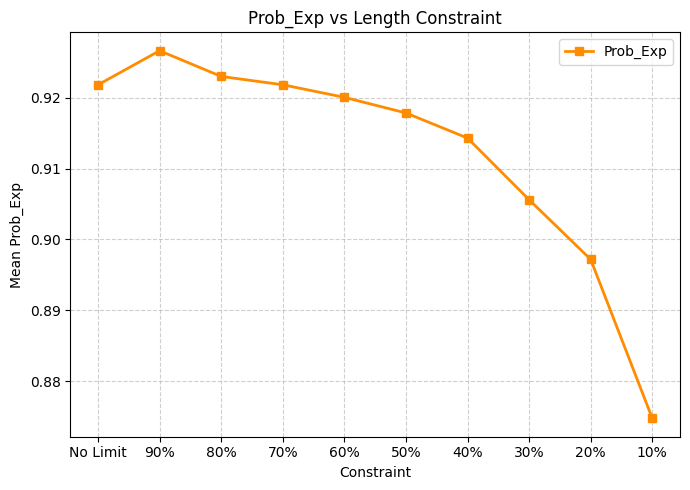

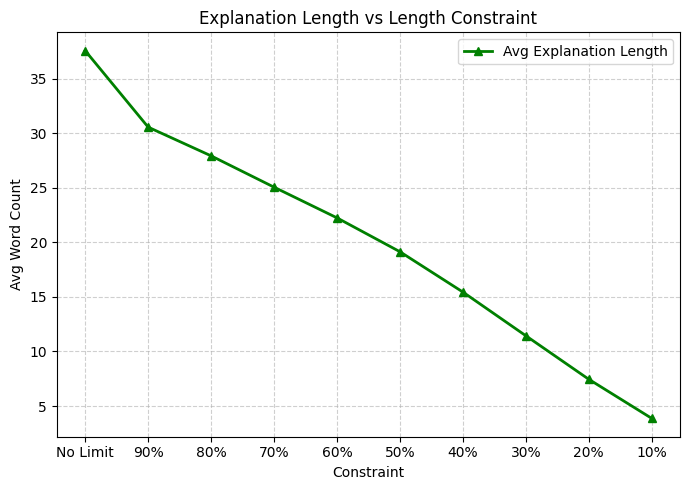

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ─────── Load All Eval CSVs ───────
file_paths = [
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_0.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_10.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_20.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_30.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_40.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_50.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_60.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_70.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_80.csv",
    "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_90.csv",
    

]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        removed_pct = int(file.split("_")[-1].replace(".csv", ""))  # e.g. 20
        df["removed_percent"] = removed_pct

        # Compute explanation length
        if "masked_explanation" in df.columns:
            df["masked_exp_len"] = df["masked_explanation"].astype(str).apply(lambda x: len(x.split()))

        dfs.append(df)

eval_data = pd.concat(dfs, ignore_index=True)

# ─────── Aggregate ───────
metrics = eval_data.groupby("removed_percent").agg({
    "prob_exp": "mean",
    "masked_exp_len": "mean"
}).reset_index()

# ✅ CHANGED: Reverse order - start with highest constraint
order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
labels = ["No Limit", "90%", "80%", "70%", "60%", "50%", "40%", "30%", "20%", "10%"]
metrics = metrics.set_index("removed_percent").loc[order].reset_index()

print("\n📊 Summary per Constraint:")
print(metrics)

# ─────── Plot Prob_Exp ───────
plt.figure(figsize=(7,5))
plt.plot(labels, metrics["prob_exp"], marker="s", color="darkorange", linewidth=2, label="Prob_Exp")
plt.xlabel("Constraint")
plt.ylabel("Mean Prob_Exp")
plt.title("Prob_Exp vs Length Constraint")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ─────── Plot Explanation Length ───────
plt.figure(figsize=(7,5))
plt.plot(labels, metrics["masked_exp_len"], marker="^", color="green", linewidth=2, label="Avg Explanation Length")
plt.xlabel("Constraint")
plt.ylabel("Avg Word Count")
plt.title("Explanation Length vs Length Constraint")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
metrics

,removed_percent,prob_exp,masked_exp_len
0,0,0.921843,37.550949
1,90,0.926663,30.549012
2,80,0.923030,27.919024
3,70,0.921853,25.051530
4,60,0.920079,22.239830
5,50,0.917870,19.137544
6,40,0.914325,15.445564
7,30,0.905614,11.442852
8,20,0.897178,7.454862
9,10,0.874734,3.874467


<Figure size 800x600 with 0 Axes>

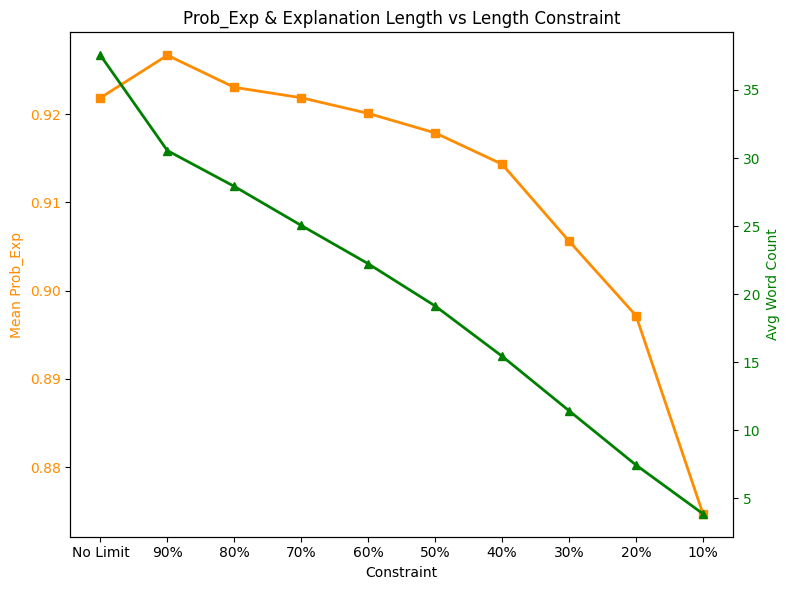

In [5]:
plt.figure(figsize=(8,6))

fig, ax1 = plt.subplots(figsize=(8,6))

# Left axis: prob_exp
color = "darkorange"
ax1.set_xlabel("Constraint")
ax1.set_ylabel("Mean Prob_Exp", color=color)
ax1.plot(labels, metrics["prob_exp"], marker="s", color=color, linewidth=2, label="Prob_Exp")
ax1.tick_params(axis="y", labelcolor=color)

# Right axis: explanation length
ax2 = ax1.twinx()
color = "green"
ax2.set_ylabel("Avg Word Count", color=color)
ax2.plot(labels, metrics["masked_exp_len"], marker="^", color=color, linewidth=2, label="Explanation Length")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Prob_Exp & Explanation Length vs Length Constraint")
fig.tight_layout()
plt.show()


## All models in ONE

In [23]:
import pandas as pd
import os

model_files = {
    "Gemini-2.0-Flash": [
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_0.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_10.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_20.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_30.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_40.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_50.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_60.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_70.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_80.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gemini/eval_gemini_2.0_flash_90.csv",
    ],

    "GPT-4o-Mini": [
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/eval_gpt_4o_mini_0.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/eval_gpt_4o_mini_10.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/eval_gpt_4o_mini_20.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/eval_gpt_4o_mini_30.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/eval_gpt_4o_mini_40.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/eval_gpt_4o_mini_50.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/eval_gpt_4o_mini_60.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/eval_gpt_4o_mini_70.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/eval_gpt_4o_mini_80.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/gpt_4o_mini/eval_gpt_4o_mini_90.csv",
    ],
    
    "Claude-3-Haiku": [
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_0.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_10.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_20.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_30.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_40.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_50.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_60.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_70.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_80.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/claude/eval_claude_3_haiku_90.csv",
    ],
    
    "Llama-4-Maverik": [
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_0.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_10.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_20.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_30.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_40.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_50.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_60.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_70.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_80.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/en/llama/eval_llama_4_maverik_90.csv",
    ],
}

def process_model(file_list):
    dfs = []
    for file in file_list:
        if os.path.exists(file):
            #print(f"✅ Found: {file}")
            df = pd.read_csv(file)
            removed_pct = int(file.split("_")[-1].replace(".csv", ""))  # e.g. 20
            df["removed_percent"] = removed_pct

            # Compute explanation length
            if "masked_explanation" in df.columns:
                df["masked_exp_len"] = df["masked_explanation"].astype(str).apply(lambda x: len(x.split()))

            dfs.append(df)

    eval_data = pd.concat(dfs, ignore_index=True)

    # Aggregate
    metrics = eval_data.groupby("removed_percent").agg({
        "prob_exp": "mean",
        "masked_exp_len": "mean",
        "is_correct_exp": "mean"   # Accuracy با explanation
    }).reset_index()

    # مرتب‌سازی به ترتیب خاص
    order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
    metrics = metrics.set_index("removed_percent").loc[order].reset_index()

    return metrics

# ─────── ساخت دیکشنری all_models_metrics ───────
all_models_metrics = {}
for model_name, file_list in model_files.items():
    all_models_metrics[model_name] = process_model(file_list)

# تست
for name, df in all_models_metrics.items():
    print(f"\n📊 {name}")
    print(df.head())


📊 Gemini-2.0-Flash
   removed_percent  prob_exp  masked_exp_len  is_correct_exp
0                0  0.921843       37.550949        0.897714
1               90  0.926663       30.549012        0.902363
2               80  0.923030       27.919024        0.901976
3               70  0.921853       25.051530        0.895777
4               60  0.920079       22.239830        0.888415

📊 GPT-4o-Mini
   removed_percent  prob_exp  masked_exp_len  is_correct_exp
0                0  0.936555       57.185587        0.893452
1               90  0.932254       39.905850        0.892290
2               80  0.933008       36.798528        0.893065
3               70  0.927384       33.139868        0.890740
4               60  0.922208       28.840372        0.880279

📊 Claude-3-Haiku
   removed_percent  prob_exp  masked_exp_len  is_correct_exp
0                0  0.929116       57.371949        0.862069
1               90  0.922947       31.168539        0.857032
2               80  0.921072    

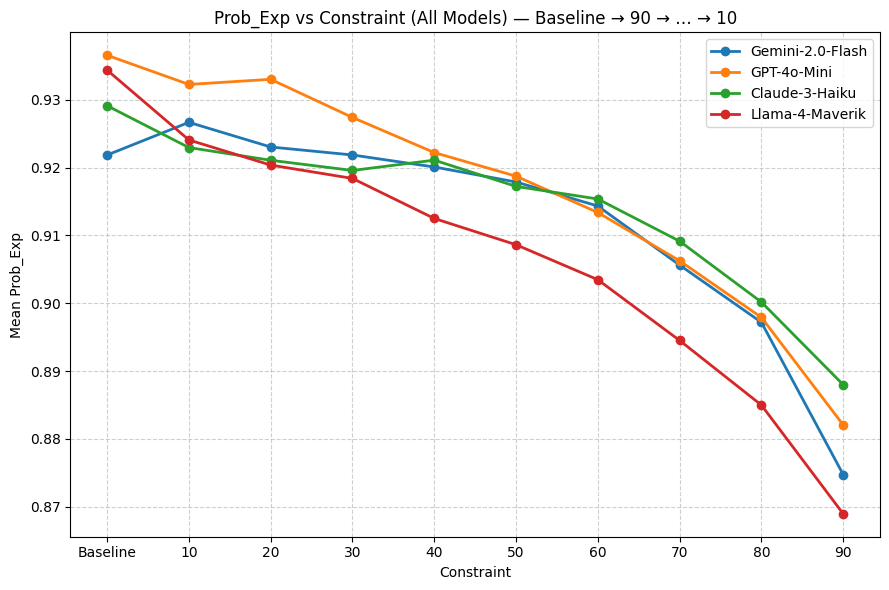

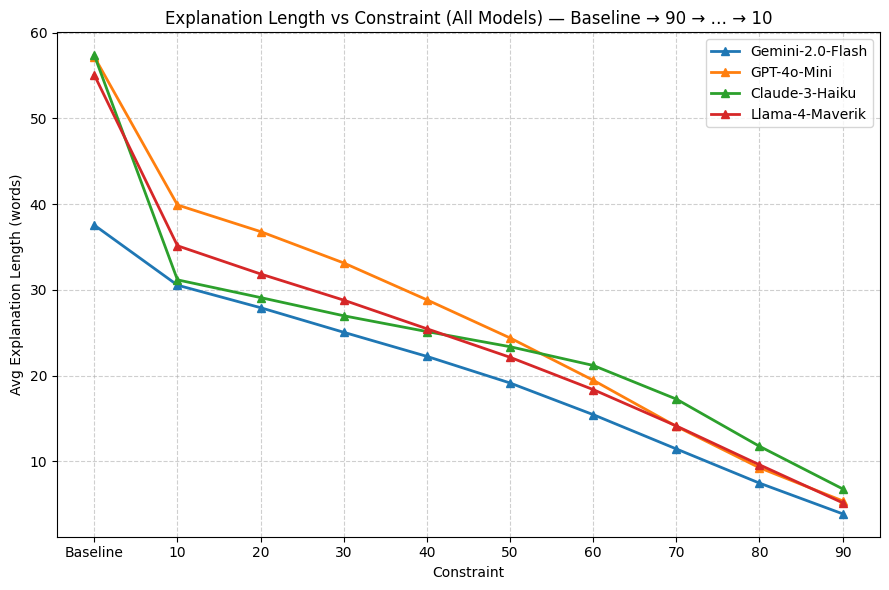

In [24]:
import matplotlib.pyplot as plt

# ترتیب دلخواه محور X
order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
labels = ["Baseline", "10", "20", "30", "40", "50", "60", "70", "80", "90"]
x_full = list(range(len(order)))  # 0..9

# ───────── Prob_Exp (همه مدل‌ها در یک نمودار) ─────────
plt.figure(figsize=(9,6))
for model_name, metrics in all_models_metrics.items():
    idxed = metrics.set_index("removed_percent")
    # فقط درصدهایی که برای این مدل موجود است
    avail = [p for p in order if p in idxed.index]
    x = [order.index(p) for p in avail]                         # اندیس ترتیبی
    y = idxed.loc[avail, "prob_exp"].values
    plt.plot(x, y, marker="o", linewidth=2, label=model_name)

plt.xticks(x_full, labels)
plt.xlabel("Constraint")
plt.ylabel("Mean Prob_Exp")
plt.title("Prob_Exp vs Constraint (All Models) — Baseline → 90 → … → 10")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ───────── Explanation Length (همه مدل‌ها در یک نمودار) ─────────
plt.figure(figsize=(9,6))
for model_name, metrics in all_models_metrics.items():
    idxed = metrics.set_index("removed_percent")
    avail = [p for p in order if p in idxed.index]
    x = [order.index(p) for p in avail]
    y = idxed.loc[avail, "masked_exp_len"].values
    plt.plot(x, y, marker="^", linewidth=2, label=model_name)

plt.xticks(x_full, labels)
plt.xlabel("Constraint")
plt.ylabel("Avg Explanation Length (words)")
plt.title("Explanation Length vs Constraint (All Models) — Baseline → 90 → … → 10")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


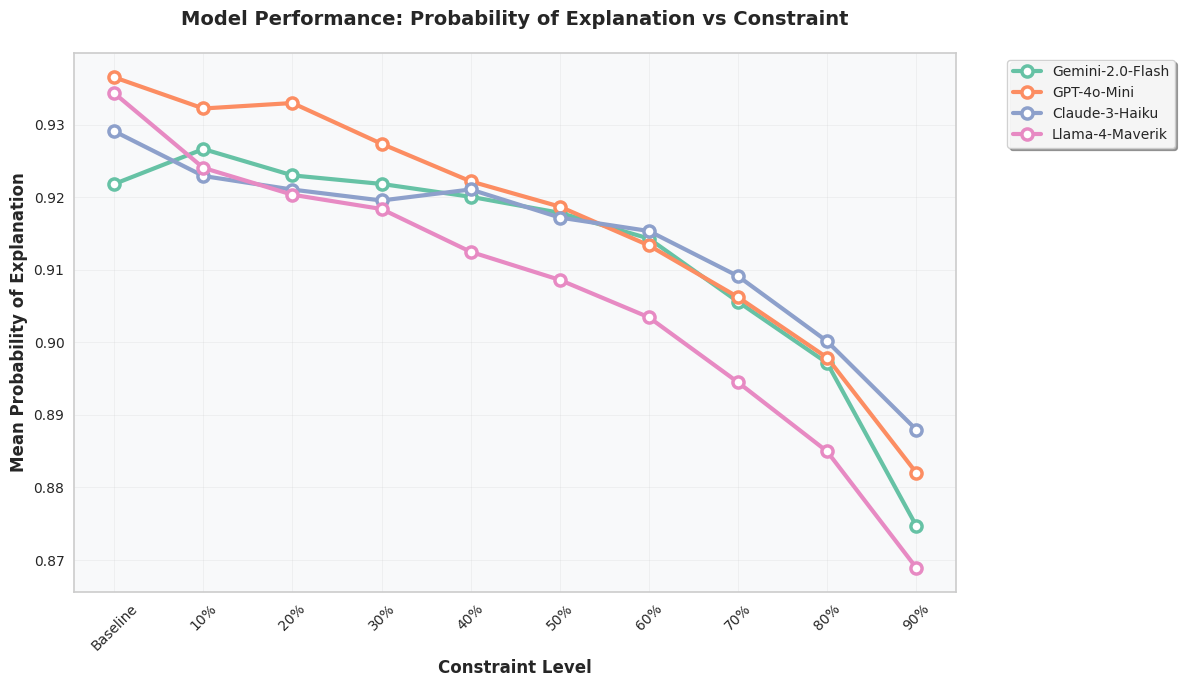

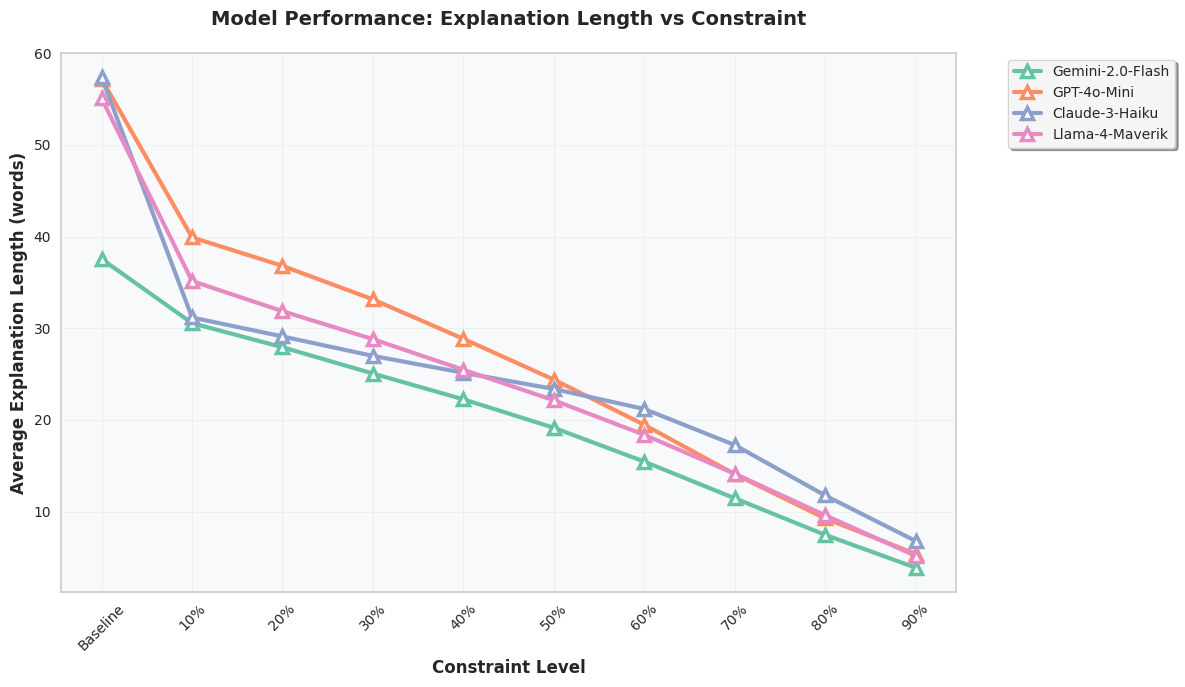

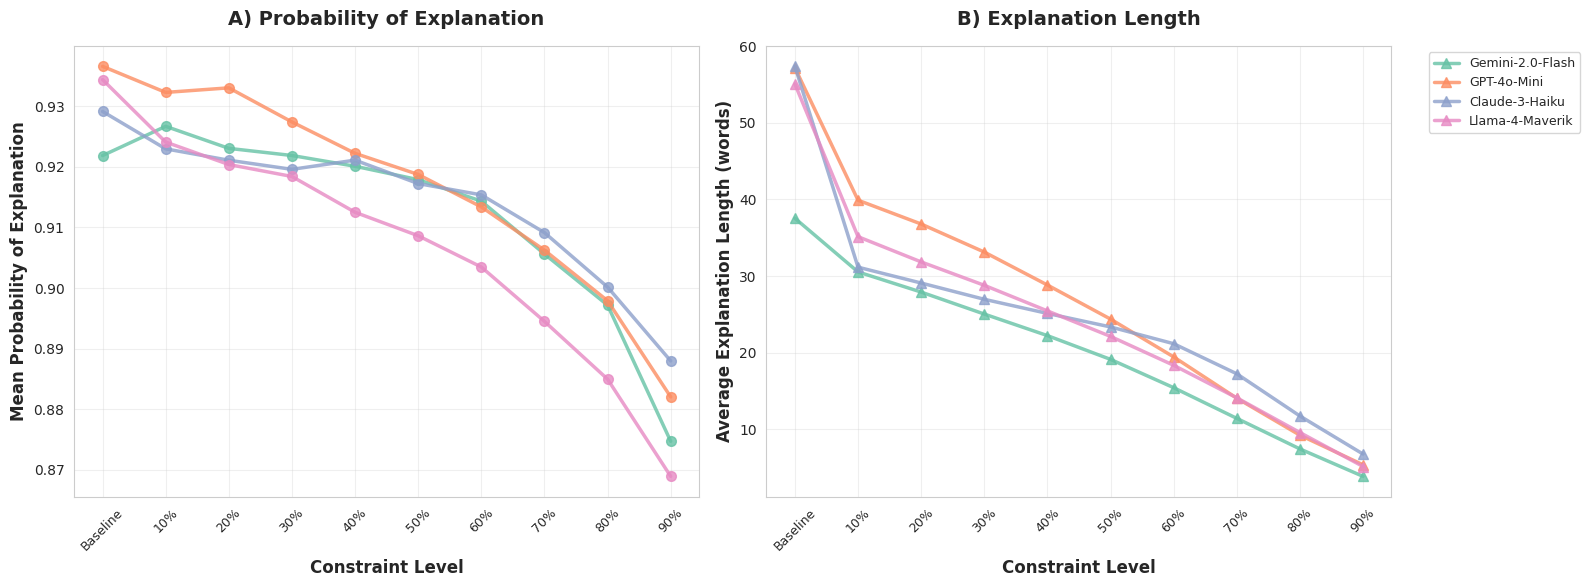

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set modern seaborn style
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Configuration
order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]

# Create a modern color palette
colors = sns.color_palette("Set2", n_colors=len(all_models_metrics))

# ═══════════════════════════════════════════════════════════════════════════════
# Modern Seaborn-style Plots
# ═══════════════════════════════════════════════════════════════════════════════

def create_enhanced_plot(metric_name, ylabel, title, marker_style="o"):
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for i, (model_name, metrics) in enumerate(all_models_metrics.items()):
        idxed = metrics.set_index("removed_percent")
        avail = [p for p in order if p in idxed.index]
        x = [order.index(p) for p in avail]
        y = idxed.loc[avail, metric_name].values
        
        # Create smooth line plot
        ax.plot(x, y,
               marker=marker_style,
               linewidth=3,
               markersize=8,
               label=model_name,
               color=colors[i],
               markerfacecolor='white',
               markeredgewidth=2.5,
               markeredgecolor=colors[i])
    
    # Styling
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45 if len(labels) > 8 else 0)
    ax.set_xlabel("Constraint Level", fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_title(title, fontweight='bold', pad=20)
    
    # Enhanced grid and background
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_facecolor('#f8f9fa')
    
    # Professional legend
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                      frameon=True, fancybox=True, shadow=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Add subtle border
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('#cccccc')
    
    plt.tight_layout()
    return fig

# Create the plots
fig1 = create_enhanced_plot("prob_exp", 
                           "Mean Probability of Explanation", 
                           "Model Performance: Probability of Explanation vs Constraint",
                           "o")
plt.show()

fig2 = create_enhanced_plot("masked_exp_len", 
                           "Average Explanation Length (words)", 
                           "Model Performance: Explanation Length vs Constraint",
                           "^")
plt.show()

# ═══════════════════════════════════════════════════════════════════════════════
# Publication-Ready Combined Plot
# ═══════════════════════════════════════════════════════════════════════════════
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics_info = [
    ("prob_exp", "Mean Probability of Explanation", "o", "A) Probability of Explanation"),
    ("masked_exp_len", "Average Explanation Length (words)", "^", "B) Explanation Length")
]

for ax_idx, (metric, ylabel, marker, title) in enumerate(metrics_info):
    ax = axes[ax_idx]
    
    for i, (model_name, metrics) in enumerate(all_models_metrics.items()):
        idxed = metrics.set_index("removed_percent")
        avail = [p for p in order if p in idxed.index]
        x = [order.index(p) for p in avail]
        y = idxed.loc[avail, metric].values
        
        ax.plot(x, y,
               marker=marker,
               linewidth=2.5,
               markersize=7,
               label=model_name,
               color=colors[i],
               alpha=0.8)
    
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, fontsize=9)
    ax.set_xlabel("Constraint Level", fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_title(title, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3)
    
    if ax_idx == 1:  # Only show legend on the right plot
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

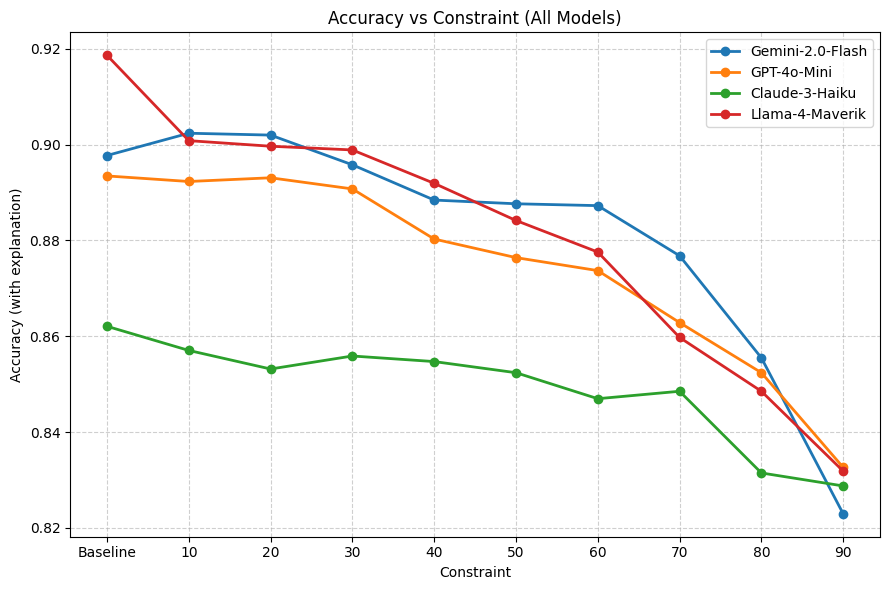

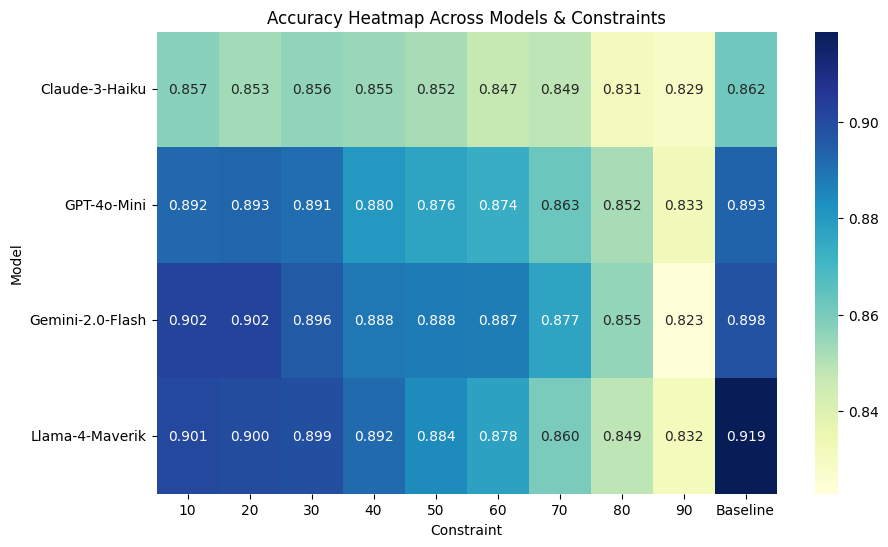

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# ترتیب محور X
order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
labels = ["Baseline", "10", "20", "30", "40", "50", "60", "70", "80", "90"]
x_full = np.arange(len(order))

# ───── 1. Line chart: Accuracy with explanation ─────
plt.figure(figsize=(9,6))
for model_name, metrics in all_models_metrics.items():
    idxed = metrics.set_index("removed_percent")
    avail = [p for p in order if p in idxed.index]
    x = [order.index(p) for p in avail]
    y = idxed.loc[avail, "is_correct_exp"].values
    plt.plot(x, y, marker="o", linewidth=2, label=model_name)

plt.xticks(x_full, labels)
plt.xlabel("Constraint")
plt.ylabel("Accuracy (with explanation)")
plt.title("Accuracy vs Constraint (All Models)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ───── 3. Heatmap: Accuracy with explanation ─────
data = []
for model_name, metrics in all_models_metrics.items():
    for p, lab in zip(order, labels):
        row = metrics[metrics["removed_percent"]==p]
        if not row.empty:
            data.append([model_name, lab, row["is_correct_exp"].values[0]])

df_heat = pd.DataFrame(data, columns=["Model","Constraint","Accuracy"])
pivot = df_heat.pivot(index="Model", columns="Constraint", values="Accuracy")

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap Across Models & Constraints")
plt.show()


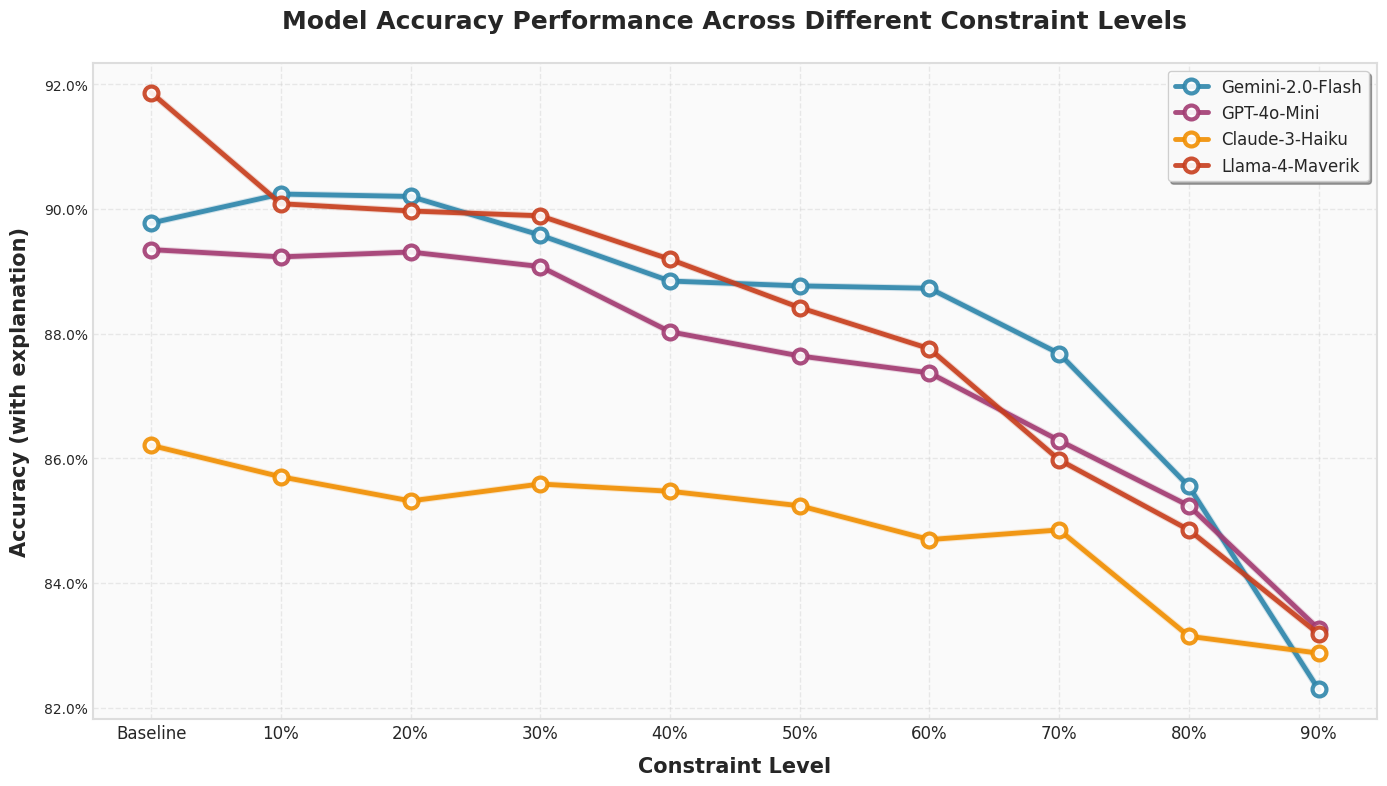

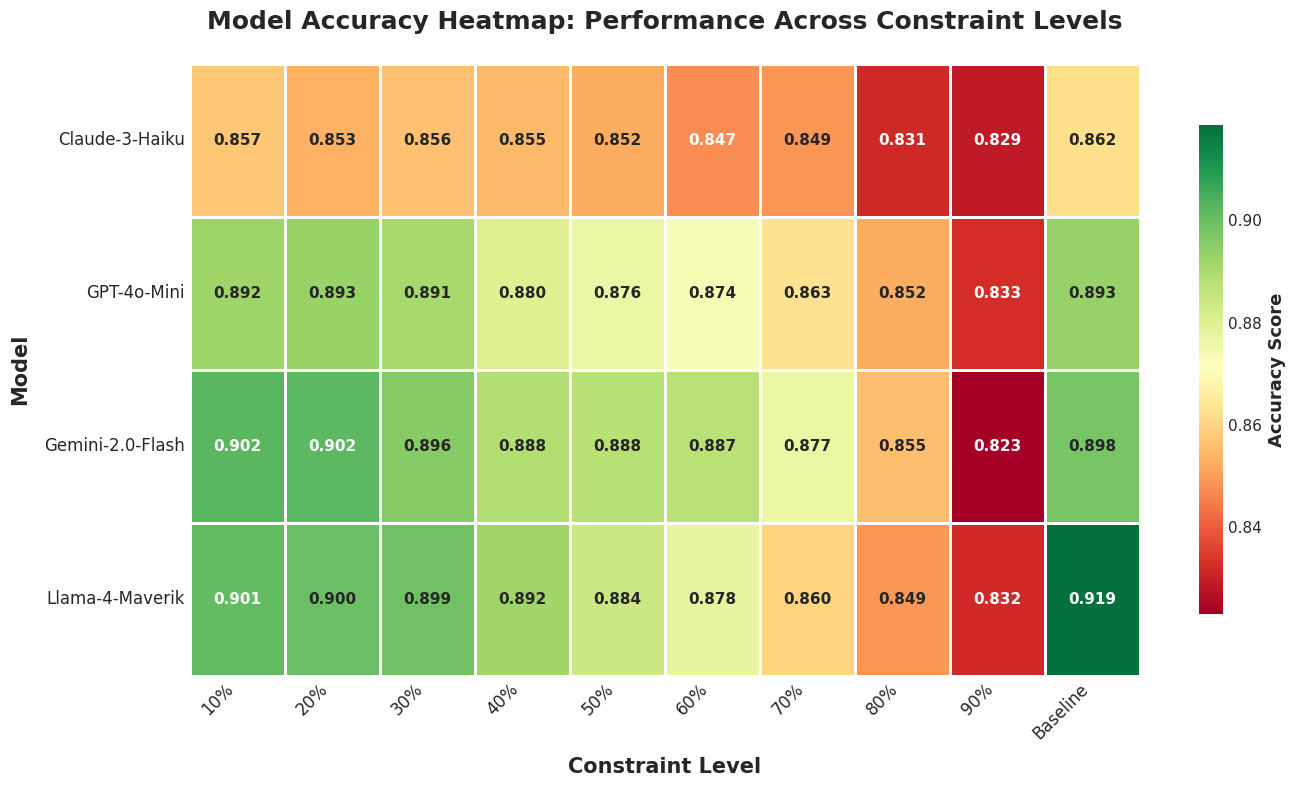

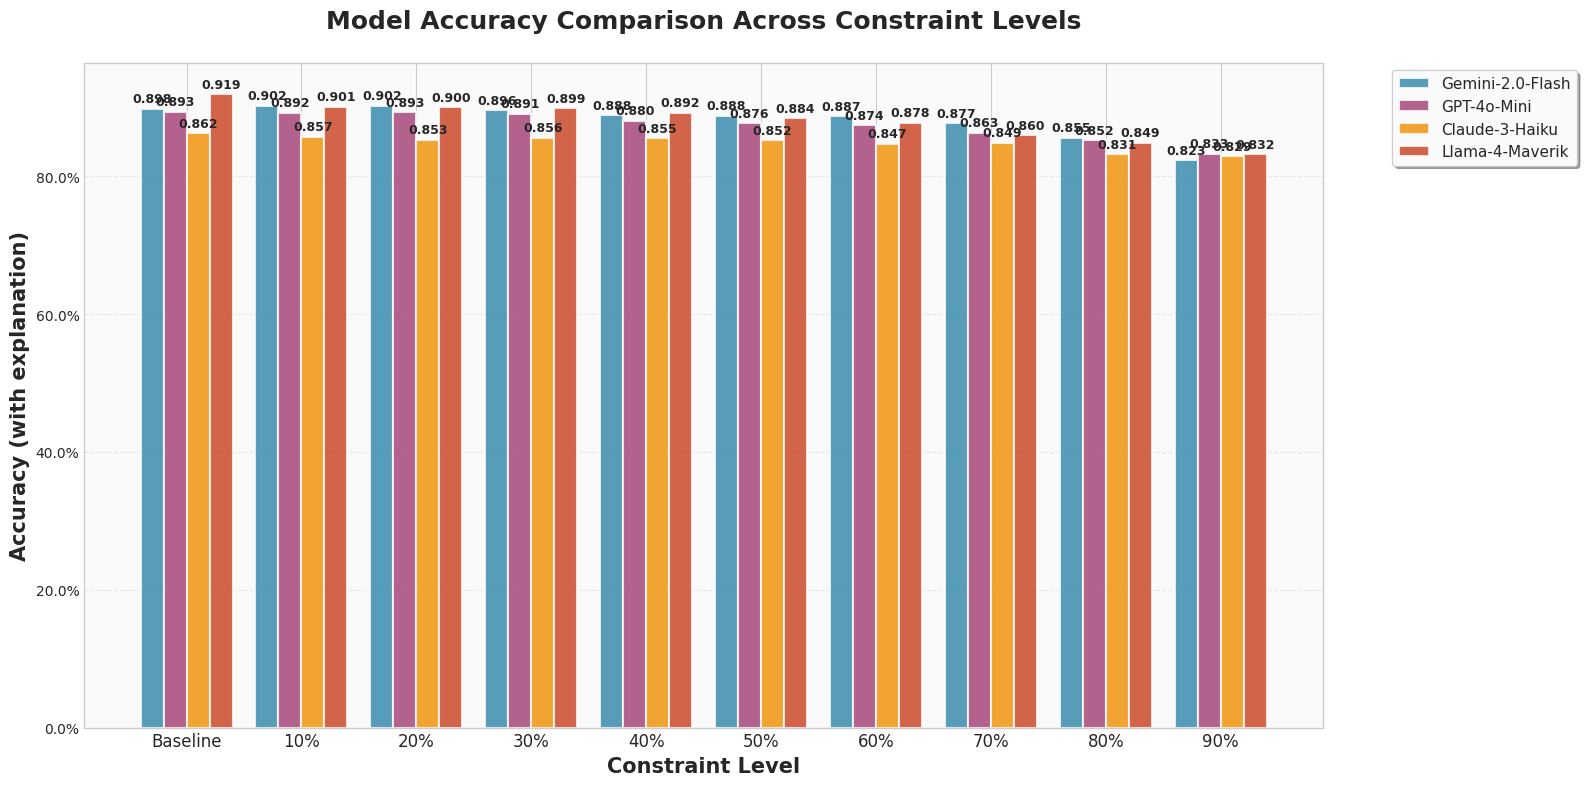

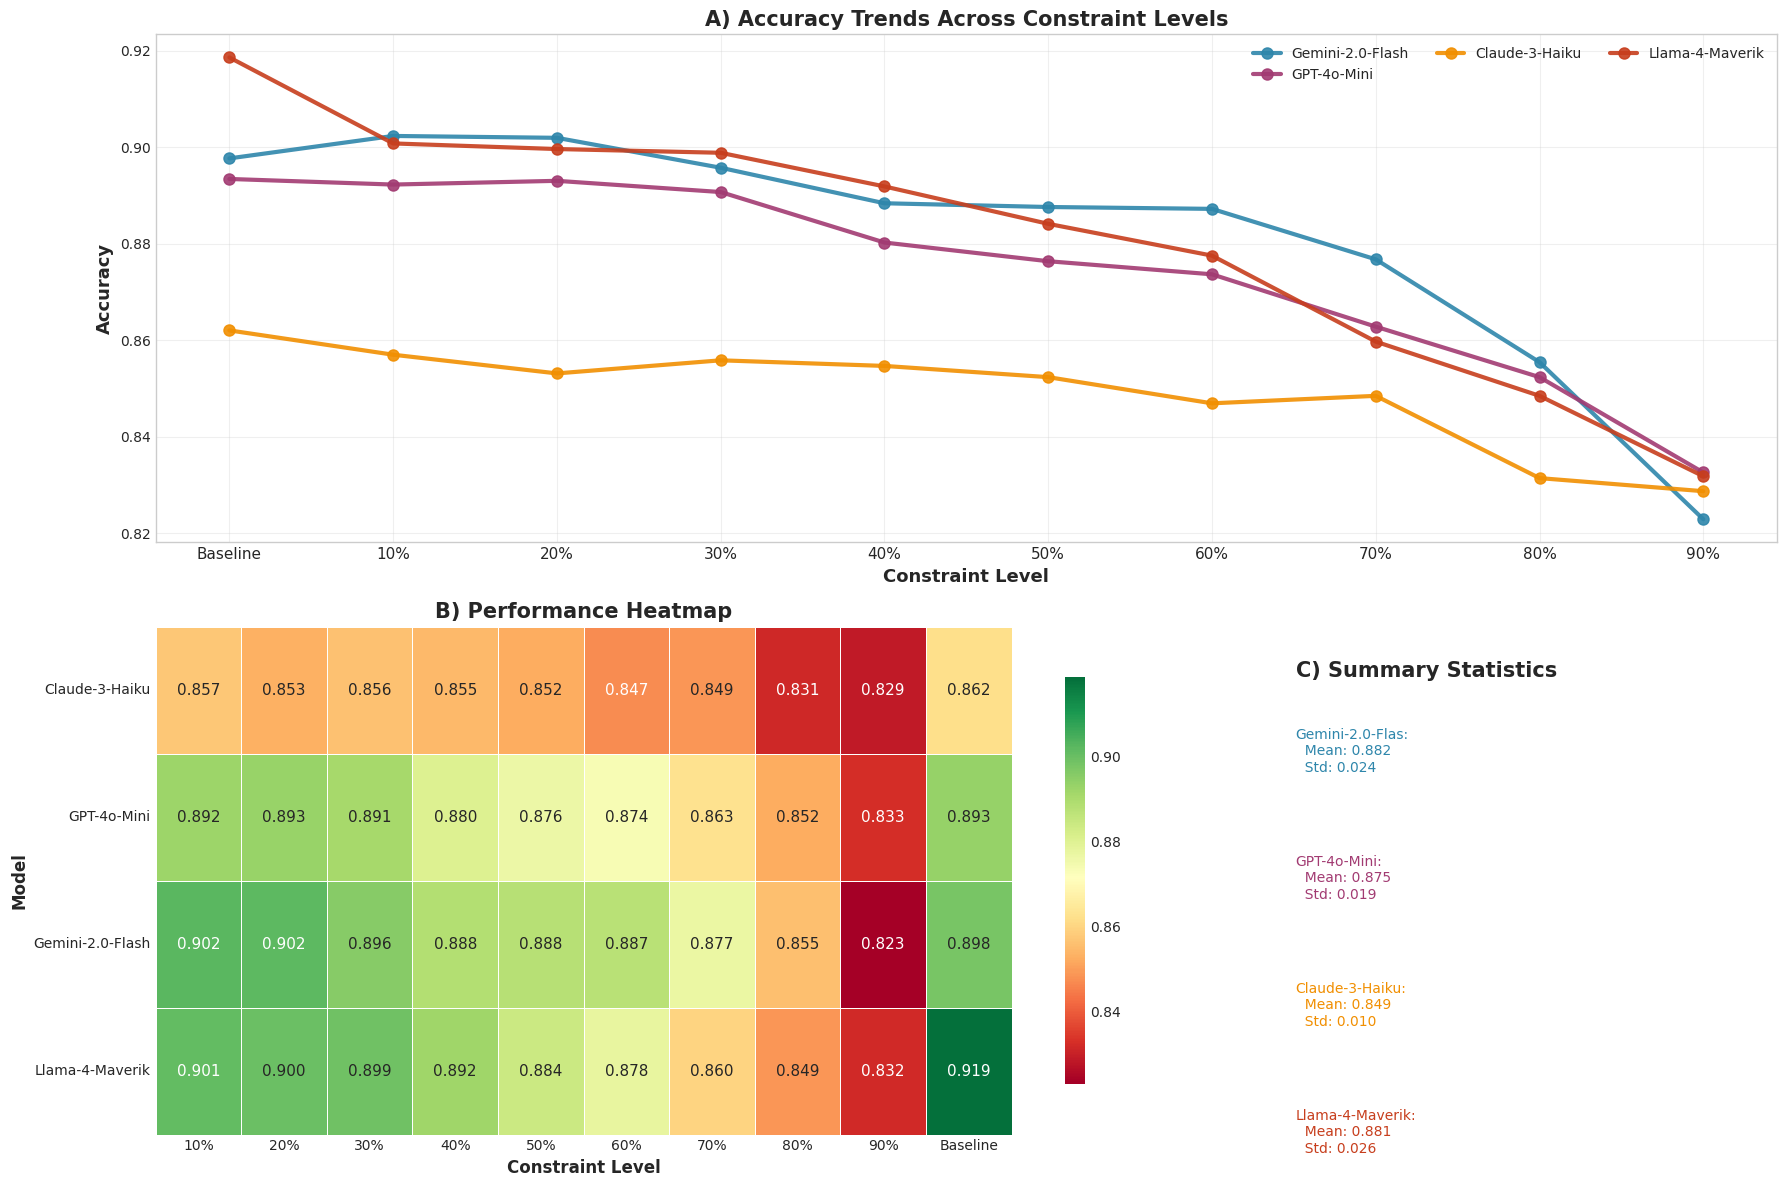

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle

# Set modern styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configuration
order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
x_full = np.arange(len(order))

# Enhanced color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7', '#2F9B69', '#F4B942', '#8B5A3C']

# ═══════════════════════════════════════════════════════════════════════════════
# Enhanced Line Chart: Accuracy with Explanation
# ═══════════════════════════════════════════════════════════════════════════════
fig, ax = plt.subplots(figsize=(14, 8))

for i, (model_name, metrics) in enumerate(all_models_metrics.items()):
    idxed = metrics.set_index("removed_percent")
    avail = [p for p in order if p in idxed.index]
    x = [order.index(p) for p in avail]
    y = idxed.loc[avail, "is_correct_exp"].values
    
    # Enhanced line plot with better styling
    ax.plot(x, y, 
           marker="o", 
           linewidth=3.5, 
           markersize=10,
           label=model_name,
           color=colors[i % len(colors)],
           markerfacecolor='white',
           markeredgewidth=3,
           markeredgecolor=colors[i % len(colors)],
           alpha=0.9)
    
    # Add subtle shadow effect
    ax.plot(x, y, 
           linewidth=5, 
           color=colors[i % len(colors)],
           alpha=0.2,
           zorder=0)

# Customize the plot
ax.set_xticks(x_full)
ax.set_xticklabels(labels, fontsize=12, fontweight='medium')
ax.set_xlabel("Constraint Level", fontsize=15, fontweight='bold', labelpad=10)
ax.set_ylabel("Accuracy (with explanation)", fontsize=15, fontweight='bold', labelpad=10)
ax.set_title("Model Accuracy Performance Across Different Constraint Levels", 
             fontsize=18, fontweight='bold', pad=25)

# Enhanced grid and styling
ax.grid(True, linestyle="--", alpha=0.4, linewidth=1)
ax.set_facecolor('#fafafa')

# Add y-axis percentage formatting
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Professional legend with box
legend = ax.legend(frameon=True, fancybox=True, shadow=True, 
                  fontsize=12, loc='best', ncol=2 if len(all_models_metrics) > 4 else 1)
legend.get_frame().set_facecolor('#ffffff')
legend.get_frame().set_alpha(0.95)
legend.get_frame().set_edgecolor('#cccccc')

# Add some visual enhancements
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('#dddddd')

plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════════════
# Enhanced Heatmap: Accuracy with Explanation
# ═══════════════════════════════════════════════════════════════════════════════
# Prepare data for heatmap
data = []
for model_name, metrics in all_models_metrics.items():
    for p, lab in zip(order, labels):
        row = metrics[metrics["removed_percent"]==p]
        if not row.empty:
            data.append([model_name, lab, row["is_correct_exp"].values[0]])

df_heat = pd.DataFrame(data, columns=["Model","Constraint","Accuracy"])
pivot = df_heat.pivot(index="Model", columns="Constraint", values="Accuracy")

# Create enhanced heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Custom colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create heatmap with enhanced styling
sns.heatmap(pivot, 
           annot=True, 
           fmt=".3f", 
           cmap="RdYlGn",
           center=pivot.values.mean(),
           linewidths=1,
           linecolor='white',
           cbar_kws={
               "shrink": 0.8,
               "label": "Accuracy Score",
               "orientation": "vertical"
           },
           annot_kws={"size": 11, "weight": "bold"},
           ax=ax)

# Customize the heatmap
ax.set_title("Model Accuracy Heatmap: Performance Across Constraint Levels", 
             fontsize=18, fontweight='bold', pad=25)
ax.set_xlabel("Constraint Level", fontsize=15, fontweight='bold', labelpad=10)
ax.set_ylabel("Model", fontsize=15, fontweight='bold', labelpad=10)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Add colorbar label styling
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
cbar.set_label("Accuracy Score", fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════════════
# Alternative: Grouped Bar Chart for Better Comparison
# ═══════════════════════════════════════════════════════════════════════════════
fig, ax = plt.subplots(figsize=(16, 8))

# Prepare data for grouped bar chart
models = list(all_models_metrics.keys())
n_models = len(models)
n_constraints = len(labels)

# Create matrix for bar chart
accuracy_matrix = np.zeros((n_models, n_constraints))
for i, (model_name, metrics) in enumerate(all_models_metrics.items()):
    idxed = metrics.set_index("removed_percent")
    for j, p in enumerate(order):
        if p in idxed.index:
            accuracy_matrix[i, j] = idxed.loc[p, "is_correct_exp"]

# Create grouped bar chart
bar_width = 0.8 / n_models
x_pos = np.arange(n_constraints)

for i, model_name in enumerate(models):
    offset = (i - n_models/2 + 0.5) * bar_width
    bars = ax.bar(x_pos + offset, accuracy_matrix[i], 
                 bar_width, 
                 label=model_name,
                 color=colors[i % len(colors)],
                 alpha=0.8,
                 edgecolor='white',
                 linewidth=1.5)
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:  # Only add label if there's data
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize the plot
ax.set_xlabel("Constraint Level", fontsize=15, fontweight='bold')
ax.set_ylabel("Accuracy (with explanation)", fontsize=15, fontweight='bold')
ax.set_title("Model Accuracy Comparison Across Constraint Levels", 
             fontsize=18, fontweight='bold', pad=25)

ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Enhanced grid and styling
ax.grid(True, axis='y', linestyle="--", alpha=0.4)
ax.set_facecolor('#fafafa')

# Professional legend
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                  frameon=True, fancybox=True, shadow=True, fontsize=11)
legend.get_frame().set_facecolor('#ffffff')
legend.get_frame().set_alpha(0.95)

plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════════════
# Modern Dashboard View: Combined Visualization
# ═══════════════════════════════════════════════════════════════════════════════
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[2, 1])

# Top-left: Line plot
ax1 = fig.add_subplot(gs[0, :])
for i, (model_name, metrics) in enumerate(all_models_metrics.items()):
    idxed = metrics.set_index("removed_percent")
    avail = [p for p in order if p in idxed.index]
    x = [order.index(p) for p in avail]
    y = idxed.loc[avail, "is_correct_exp"].values
    
    ax1.plot(x, y, 
            marker="o", 
            linewidth=3, 
            markersize=8,
            label=model_name,
            color=colors[i % len(colors)],
            alpha=0.9)

ax1.set_xticks(x_full)
ax1.set_xticklabels(labels, fontsize=11)
ax1.set_xlabel("Constraint Level", fontsize=13, fontweight='bold')
ax1.set_ylabel("Accuracy", fontsize=13, fontweight='bold')
ax1.set_title("A) Accuracy Trends Across Constraint Levels", fontsize=15, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10, ncol=3)

# Bottom-left: Heatmap
ax2 = fig.add_subplot(gs[1, 0])
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="RdYlGn", 
           center=pivot.values.mean(), linewidths=0.5, ax=ax2,
           cbar_kws={"shrink": 0.8})
ax2.set_title("B) Performance Heatmap", fontsize=15, fontweight='bold')
ax2.set_xlabel("Constraint Level", fontsize=12, fontweight='bold')
ax2.set_ylabel("Model", fontsize=12, fontweight='bold')

# Bottom-right: Summary statistics
ax3 = fig.add_subplot(gs[1, 1])
summary_stats = []
for model_name, metrics in all_models_metrics.items():
    idxed = metrics.set_index("removed_percent")
    avail_values = [idxed.loc[p, "is_correct_exp"] for p in order if p in idxed.index]
    summary_stats.append({
        'Model': model_name,
        'Mean': np.mean(avail_values),
        'Std': np.std(avail_values),
        'Max': np.max(avail_values),
        'Min': np.min(avail_values)
    })

summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.round(3)

# Create text-based summary
ax3.axis('off')
ax3.text(0.1, 0.9, "C) Summary Statistics", fontsize=15, fontweight='bold', 
         transform=ax3.transAxes)

y_pos = 0.8
for idx, row in summary_df.iterrows():
    text = f"{row['Model'][:15]}:\n  Mean: {row['Mean']:.3f}\n  Std: {row['Std']:.3f}"
    ax3.text(0.1, y_pos, text, fontsize=10, transform=ax3.transAxes,
            verticalalignment='top', color=colors[idx % len(colors)],
            fontweight='medium')
    y_pos -= 0.25

plt.tight_layout()
plt.show()

In [39]:
import pandas as pd
import numpy as np

# ترتیب دلخواه محور/ستون‌ها
order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
labels_map = {0: "Baseline", 90: "10", 80: "20", 70: "30", 60: "40", 50: "50",
              40: "60", 30: "70", 20: "80", 10: "90"}

# ساخت جدول طولی (long/tidy) با هر سه متریک
rows = []
for model_name, metrics in all_models_metrics.items():
    m = metrics.set_index("removed_percent")
    for p in order:
        constraint_label = labels_map[p]
        acc = m.loc[p, "is_correct_exp"] if ("is_correct_exp" in m.columns and p in m.index) else np.nan
        prob = m.loc[p, "prob_exp"]        if ("prob_exp"        in m.columns and p in m.index) else np.nan
        length = m.loc[p, "masked_exp_len"] if ("masked_exp_len" in m.columns and p in m.index) else np.nan
        rows.append({
            "Model": model_name,
            "Constraint": constraint_label,
            "Accuracy": acc,
            "Prob_Exp": prob,
            "Avg_Exp_Len": length
        })

tidy = pd.DataFrame(rows)

# رُند کردن اعداد برای نمایش
tidy["Accuracy"] = tidy["Accuracy"].round(3)
tidy["Prob_Exp"] = tidy["Prob_Exp"].round(3)
tidy["Avg_Exp_Len"] = tidy["Avg_Exp_Len"].round(1)

# ---- جدول مارک‌داون طولی (کامل) ----
print("\n### Full Results (Accuracy, Prob_Exp, Length)\n")
print(tidy.fillna("–").to_markdown(index=False))

# ---- جداول Pivot جدا برای هر متریک ----
# ترتیب ستون‌ها: Baseline → 90 → 80 → … → 10
cols_order = ["Baseline", "90", "80", "70", "60", "50", "40", "30", "20", "10"]

acc_table = tidy.pivot(index="Model", columns="Constraint", values="Accuracy").reindex(columns=cols_order)
prob_table = tidy.pivot(index="Model", columns="Constraint", values="Prob_Exp").reindex(columns=cols_order)
len_table = tidy.pivot(index="Model", columns="Constraint", values="Avg_Exp_Len").reindex(columns=cols_order)



### Full Results (Accuracy, Prob_Exp, Length)

| Model            | Constraint   |   Accuracy |   Prob_Exp |   Avg_Exp_Len |
|:-----------------|:-------------|-----------:|-----------:|--------------:|
| Gemini-2.0-Flash | Baseline     |      0.898 |      0.922 |          37.6 |
| Gemini-2.0-Flash | 10           |      0.902 |      0.927 |          30.5 |
| Gemini-2.0-Flash | 20           |      0.902 |      0.923 |          27.9 |
| Gemini-2.0-Flash | 30           |      0.896 |      0.922 |          25.1 |
| Gemini-2.0-Flash | 40           |      0.888 |      0.92  |          22.2 |
| Gemini-2.0-Flash | 50           |      0.888 |      0.918 |          19.1 |
| Gemini-2.0-Flash | 60           |      0.887 |      0.914 |          15.4 |
| Gemini-2.0-Flash | 70           |      0.877 |      0.906 |          11.4 |
| Gemini-2.0-Flash | 80           |      0.855 |      0.897 |           7.5 |
| Gemini-2.0-Flash | 90           |      0.823 |      0.875 |           3.9 |
| GPT-4o-Mini   

# Persian

In [ ]:
import pandas as pd
import os

model_files = {
    "Gemini-2.0-Flash": [
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gemini_2_flash/eval_gemini_2.0_flash_fa_0.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gemini_2_flash/eval_gemini_2.0_flash_fa_10.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gemini_2_flash/eval_gemini_2.0_flash_fa_20.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gemini_2_flash/eval_gemini_2.0_flash_fa_30.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gemini_2_flash/eval_gemini_2.0_flash_fa_40.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gemini_2_flash/eval_gemini_2.0_flash_fa_50.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gemini_2_flash/eval_gemini_2.0_flash_fa_60.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gemini_2_flash/eval_gemini_2.0_flash_fa_70.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gemini_2_flash/eval_gemini_2.0_flash_fa_80.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gemini_2_flash/eval_gemini_2.0_flash_fa_90.csv",
    ],

    "GPT-4o-Mini": [
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gpt-4o-mini/eval_gpt_4o_mini_fa_0.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gpt-4o-mini/eval_gpt_4o_mini_fa_10.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gpt-4o-mini/eval_gpt_4o_mini_fa_20.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gpt-4o-mini/eval_gpt_4o_mini_fa_30.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gpt-4o-mini/eval_gpt_4o_mini_fa_40.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gpt-4o-mini/eval_gpt_4o_mini_fa_50.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gpt-4o-mini/eval_gpt_4o_mini_fa_60.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gpt-4o-mini/eval_gpt_4o_mini_fa_70.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gpt-4o-mini/eval_gpt_4o_mini_fa_80.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/gpt-4o-mini/eval_gpt_4o_mini_fa_90.csv",
    ],
    
    "Claude-3-Haiku": [
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/claude_3_haiku/eval_claude_3_haiku_fa_0.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/claude_3_haiku/eval_claude_3_haiku_fa_10.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/claude_3_haiku/eval_claude_3_haiku_fa_20.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/claude_3_haiku/eval_claude_3_haiku_fa_30.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/claude_3_haiku/eval_claude_3_haiku_fa_40.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/claude_3_haiku/eval_claude_3_haiku_fa_50.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/claude_3_haiku/eval_claude_3_haiku_fa_60.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/claude_3_haiku/eval_claude_3_haiku_fa_70.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/claude_3_haiku/eval_claude_3_haiku_fa_80.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/claude_3_haiku/eval_claude_3_haiku_fa_90.csv",
    ],
    
    "Llama-4-Maverik": [
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/llama_4_maverik/eval_llama_4_maverik_masked_0.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/llama_4_maverik/eval_llama_4_maverik_masked_10.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/llama_4_maverik/eval_llama_4_maverik_masked_20.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/llama_4_maverik/eval_llama_4_maverik_masked_30.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/llama_4_maverik/eval_llama_4_maverik_masked_40.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/llama_4_maverik/eval_llama_4_maverik_masked_50.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/llama_4_maverik/eval_llama_4_maverik_masked_60.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/llama_4_maverik/eval_llama_4_maverik_masked_70.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/llama_4_maverik/eval_llama_4_maverik_masked_80.csv",
        "/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa/llama_4_maverik/eval_llama_4_maverik_masked_90.csv",
    ],
}

def process_model(file_list):
    dfs = []
    for file in file_list:
        if os.path.exists(file):
            #print(f"✅ Found: {file}")
            df = pd.read_csv(file)
            removed_pct = int(file.split("_")[-1].replace(".csv", ""))  # e.g. 20
            df["removed_percent"] = removed_pct

            # Compute explanation length
            if "masked_explanation" in df.columns:
                df["masked_exp_len"] = df["masked_explanation"].astype(str).apply(lambda x: len(x.split()))

            dfs.append(df)

    eval_data = pd.concat(dfs, ignore_index=True)

    # Aggregate
    metrics = eval_data.groupby("removed_percent").agg({
        "prob_exp": "mean",
        "masked_exp_len": "mean",
        "is_correct_exp": "mean"   # Accuracy با explanation
    }).reset_index()

    # مرتب‌سازی به ترتیب خاص
    order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
    metrics = metrics.set_index("removed_percent").loc[order].reset_index()

    return metrics

# ─────── ساخت دیکشنری all_models_metrics ───────
all_models_metrics = {}
for model_name, file_list in model_files.items():
    all_models_metrics[model_name] = process_model(file_list)

# تست
for name, df in all_models_metrics.items():
    print(f"\n📊 {name}")
    print(df.head())

In [2]:
from sentence_transformers import SentenceTransformer, util
import torch
# from .autonotebook import tqdm as notebook_tqdm

# Load the Qwen3 Embedding model
model = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B")

def explanation_similarity(base_expl, variants):
    """
    Compute cosine similarity between base explanation and its variants
    using Qwen3-Embedding-0.6B.
    """
    # Encode base and all variants
    embeddings = model.encode([base_expl] + variants, convert_to_tensor=True, normalize_embeddings=True)

    base_emb = embeddings[0]
    variant_embs = embeddings[1:]

    # Cosine similarity
    scores = util.cos_sim(base_emb, variant_embs)

    # Return as list of floats
    return [float(s) for s in scores[0]]

# Example
base = "The Earth revolves around the Sun once every year."
variants = [
    "Earth orbits the Sun yearly.",
    "Sun orbit Earth.",
    "Planets move."
]

sims = explanation_similarity(base, variants)
for v, s in zip(variants, sims):
    print(f"Similarity with base: {s:.4f} → {v}")


/home/tmptiloct15/self-explaination-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Similarity with base: 0.8783 → Earth orbits the Sun yearly.
Similarity with base: 0.4933 → Sun orbit Earth.
Similarity with base: 0.3890 → Planets move.
